In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append(r"C:\cygwin64\bin")

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import pandas as pd
from theano import tensor as T
import theano
theano.config.cxx = ""  # r"C:\cygwin64\bin\g++.exe"
theano.config.cxx

''

In [5]:
df = pd.read_csv(pm.get_data('mastectomy.csv'))
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized == 'yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

In [6]:
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [7]:
n_patients

44

In [8]:
df.event.mean()

0.5909090909090909

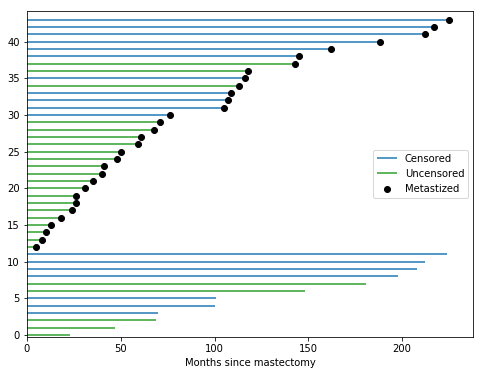

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored');

ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored');

ax.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1],
           color='k', zorder=10, label='Metastized');

ax.set_xlim(left=0);
ax.set_xlabel('Months since mastectomy');

ax.set_ylim(-0.25, n_patients + 0.25);

ax.legend(loc='center right');

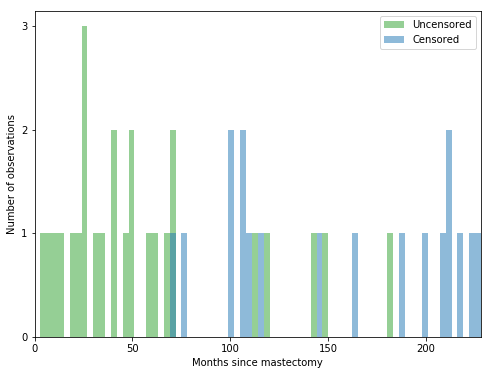

In [12]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(df[df.event == 1].time.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored')
ax.hist(df[df.event == 0].time.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored')

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel('Months since mastectomy')

ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel('Number of observations')

ax.legend()

In [13]:
last_period = np.floor(((100 * df.time) - 1) / interval_length / 100)
last_period = last_period.astype(int)  # needed because np.floor creates float64
death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event

exposure = np.greater_equal.outer(df.time, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

SEED = 5078864  # from random.org

In [14]:
with pm.Model() as model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    
    sigma = pm.Uniform('sigma', 0., 10.)
    tau = pm.Deterministic('tau', sigma**-2)
    mu_beta = pm.Normal('mu_beta', 0., 10**-2)
    beta = pm.Normal('beta', mu_beta, tau)
    
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    obs = pm.Poisson('obs', mu, observed=death)

In [18]:
n_samples = 400
burn = 2000
thin = 20

In [19]:
with model:
    step = pm.Metropolis()
    trace_ = pm.sample(n_samples, step, random_seed=SEED)

Only 400 samples in chain.


Multiprocess sampling (2 chains in 2 jobs)


CompoundStep


>Metropolis: [beta]


>Metropolis: [mu_beta]


>Metropolis: [sigma]


>Metropolis: [lambda0]


Could not pickle model, sampling singlethreaded.


Sequential sampling (2 chains in 1 job)


CompoundStep


>Metropolis: [beta]


>Metropolis: [mu_beta]


>Metropolis: [sigma]


>Metropolis: [lambda0]


  0%|          | 0/900 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Python27\Lib\threading.py", line 810, in __bootstrap_inner
    self.run()
  File "C:\Python27\Lib\threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "C:\Users\Lukas\Documents\Uni\Semester 4\Seminar\Test\venv\lib\site-packages\joblib\externals\loky\backend\queues.py", line 176, in _feed
    onerror(e, obj)
  File "C:\Users\Lukas\Documents\Uni\Semester 4\Seminar\Test\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 312, in _on_queue_feeder_error
    self.thread_wakeup.wakeup()
  File "C:\Users\Lukas\Documents\Uni\Semester 4\Seminar\Test\venv\lib\site-packages\joblib\externals\loky\process_executor.py", line 152, in wakeup
    self._writer.send_bytes(b"0")
IOError: [Errno 6] Das Handle ist ung�ltig


  0%|          | 1/900 [00:04<1:09:38,  4.65s/it]

  0%|          | 2/900 [00:07<1:01:54,  4.14s/it]

  0%|          | 3/900 [00:10<56:28,  3.78s/it]  

  0%|          | 4/900 [00:13<52:42,  3.53s/it]

  1%|          | 5/900 [00:16<49:55,  3.35s/it]

  1%|          | 6/900 [00:19<48:17,  3.24s/it]

  1%|          | 7/900 [00:22<46:55,  3.15s/it]

  1%|          | 8/900 [00:25<45:51,  3.08s/it]

  1%|          | 9/900 [00:28<45:12,  3.04s/it]

  1%|          | 10/900 [00:31<44:43,  3.02s/it]

  1%|          | 11/900 [00:34<44:33,  3.01s/it]

  1%|▏         | 12/900 [00:37<44:19,  2.99s/it]

  1%|▏         | 13/900 [00:40<44:40,  3.02s/it]

  2%|▏         | 14/900 [00:43<44:51,  3.04s/it]

  2%|▏         | 15/900 [00:48<53:31,  3.63s/it]

  2%|▏         | 16/900 [00:51<51:10,  3.47s/it]

  2%|▏         | 17/900 [00:54<48:54,  3.32s/it]

  2%|▏         | 18/900 [00:57<47:54,  3.26s/it]

  2%|▏         | 19/900 [01:01<49:48,  3.39s/it]

  2%|▏         | 20/900 [01:04<49:17,  3.36s/it]

  2%|▏         | 21/900 [01:07<47:28,  3.24s/it]

  2%|▏         | 22/900 [01:10<46:18,  3.16s/it]

  3%|▎         | 23/900 [01:13<45:08,  3.09s/it]

  3%|▎         | 24/900 [01:16<44:39,  3.06s/it]

  3%|▎         | 25/900 [01:19<44:55,  3.08s/it]

  3%|▎         | 26/900 [01:22<45:15,  3.11s/it]

  3%|▎         | 27/900 [01:25<45:19,  3.12s/it]

  3%|▎         | 28/900 [01:28<45:13,  3.11s/it]

  3%|▎         | 29/900 [01:31<45:14,  3.12s/it]

  3%|▎         | 30/900 [01:35<45:24,  3.13s/it]

  3%|▎         | 31/900 [01:38<45:17,  3.13s/it]

  4%|▎         | 32/900 [01:41<45:26,  3.14s/it]

  4%|▎         | 33/900 [01:44<45:31,  3.15s/it]

  4%|▍         | 34/900 [01:47<46:14,  3.20s/it]

  4%|▍         | 35/900 [01:51<46:44,  3.24s/it]

  4%|▍         | 36/900 [01:54<46:03,  3.20s/it]

  4%|▍         | 37/900 [01:57<45:50,  3.19s/it]

  4%|▍         | 38/900 [02:00<46:21,  3.23s/it]

  4%|▍         | 39/900 [02:04<48:03,  3.35s/it]

  4%|▍         | 40/900 [02:08<50:23,  3.52s/it]

  5%|▍         | 41/900 [02:12<50:51,  3.55s/it]

  5%|▍         | 42/900 [02:15<49:18,  3.45s/it]

  5%|▍         | 43/900 [02:18<47:41,  3.34s/it]

  5%|▍         | 44/900 [02:21<47:18,  3.32s/it]

  5%|▌         | 45/900 [02:26<52:22,  3.68s/it]

  5%|▌         | 46/900 [02:29<51:28,  3.62s/it]

  5%|▌         | 47/900 [02:32<48:37,  3.42s/it]

  5%|▌         | 48/900 [02:35<46:22,  3.27s/it]

  5%|▌         | 49/900 [02:38<44:46,  3.16s/it]

  6%|▌         | 50/900 [02:41<43:36,  3.08s/it]

  6%|▌         | 51/900 [02:44<42:48,  3.02s/it]

  6%|▌         | 52/900 [02:47<42:08,  2.98s/it]

  6%|▌         | 53/900 [02:49<41:49,  2.96s/it]

  6%|▌         | 54/900 [02:52<41:31,  2.95s/it]

  6%|▌         | 55/900 [02:55<41:14,  2.93s/it]

  6%|▌         | 56/900 [02:58<41:09,  2.93s/it]

  6%|▋         | 57/900 [03:01<41:07,  2.93s/it]

  6%|▋         | 58/900 [03:04<41:48,  2.98s/it]

  7%|▋         | 59/900 [03:07<41:28,  2.96s/it]

  7%|▋         | 60/900 [03:10<41:13,  2.94s/it]

  7%|▋         | 61/900 [03:13<40:54,  2.92s/it]

  7%|▋         | 62/900 [03:16<40:47,  2.92s/it]

  7%|▋         | 63/900 [03:19<40:40,  2.92s/it]

  7%|▋         | 64/900 [03:22<40:28,  2.91s/it]

  7%|▋         | 65/900 [03:24<40:27,  2.91s/it]

  7%|▋         | 66/900 [03:27<40:16,  2.90s/it]

  7%|▋         | 67/900 [03:30<40:16,  2.90s/it]

  8%|▊         | 68/900 [03:33<40:14,  2.90s/it]

  8%|▊         | 69/900 [03:36<40:12,  2.90s/it]

  8%|▊         | 70/900 [03:39<40:04,  2.90s/it]

  8%|▊         | 71/900 [03:42<40:05,  2.90s/it]

  8%|▊         | 72/900 [03:45<40:03,  2.90s/it]

  8%|▊         | 73/900 [03:48<40:03,  2.91s/it]

  8%|▊         | 74/900 [03:51<40:11,  2.92s/it]

  8%|▊         | 75/900 [03:54<39:56,  2.90s/it]

  8%|▊         | 76/900 [03:56<39:45,  2.90s/it]

  9%|▊         | 77/900 [03:59<39:59,  2.92s/it]

  9%|▊         | 78/900 [04:02<39:57,  2.92s/it]

  9%|▉         | 79/900 [04:05<40:01,  2.93s/it]

  9%|▉         | 80/900 [04:08<39:59,  2.93s/it]

  9%|▉         | 81/900 [04:11<39:55,  2.92s/it]

  9%|▉         | 82/900 [04:14<39:46,  2.92s/it]

  9%|▉         | 83/900 [04:17<39:51,  2.93s/it]

  9%|▉         | 84/900 [04:20<40:48,  3.00s/it]

  9%|▉         | 85/900 [04:23<41:10,  3.03s/it]

 10%|▉         | 86/900 [04:26<40:40,  3.00s/it]

 10%|▉         | 87/900 [04:29<40:23,  2.98s/it]

 10%|▉         | 88/900 [04:32<39:59,  2.96s/it]

 10%|▉         | 89/900 [04:35<39:41,  2.94s/it]

 10%|█         | 90/900 [04:38<39:27,  2.92s/it]

 10%|█         | 91/900 [04:41<39:17,  2.91s/it]

 10%|█         | 92/900 [04:43<39:01,  2.90s/it]

 10%|█         | 93/900 [04:46<38:56,  2.89s/it]

 10%|█         | 94/900 [04:49<38:56,  2.90s/it]

 11%|█         | 95/900 [04:52<38:53,  2.90s/it]

 11%|█         | 96/900 [04:55<38:54,  2.90s/it]

 11%|█         | 97/900 [04:58<38:45,  2.90s/it]

 11%|█         | 98/900 [05:01<38:44,  2.90s/it]

 11%|█         | 99/900 [05:04<38:48,  2.91s/it]

 11%|█         | 100/900 [05:07<38:40,  2.90s/it]

 11%|█         | 101/900 [05:10<38:49,  2.92s/it]

 11%|█▏        | 102/900 [05:13<38:47,  2.92s/it]

 11%|█▏        | 103/900 [05:15<38:36,  2.91s/it]

 12%|█▏        | 104/900 [05:18<38:25,  2.90s/it]

 12%|█▏        | 105/900 [05:21<38:20,  2.89s/it]

 12%|█▏        | 106/900 [05:24<38:17,  2.89s/it]

 12%|█▏        | 107/900 [05:27<38:20,  2.90s/it]

 12%|█▏        | 108/900 [05:30<38:15,  2.90s/it]

 12%|█▏        | 109/900 [05:33<38:17,  2.90s/it]

 12%|█▏        | 110/900 [05:36<38:15,  2.91s/it]

 12%|█▏        | 111/900 [05:39<38:09,  2.90s/it]

 12%|█▏        | 112/900 [05:42<38:10,  2.91s/it]

 13%|█▎        | 113/900 [05:44<38:08,  2.91s/it]

 13%|█▎        | 114/900 [05:47<38:09,  2.91s/it]

 13%|█▎        | 115/900 [05:50<38:19,  2.93s/it]

 13%|█▎        | 116/900 [05:53<38:06,  2.92s/it]

 13%|█▎        | 117/900 [05:56<38:02,  2.91s/it]

 13%|█▎        | 118/900 [05:59<37:58,  2.91s/it]

 13%|█▎        | 119/900 [06:02<37:54,  2.91s/it]

 13%|█▎        | 120/900 [06:05<37:54,  2.92s/it]

 13%|█▎        | 121/900 [06:08<37:42,  2.90s/it]

 14%|█▎        | 122/900 [06:11<37:35,  2.90s/it]

 14%|█▎        | 123/900 [06:14<38:00,  2.94s/it]

 14%|█▍        | 124/900 [06:17<38:00,  2.94s/it]

 14%|█▍        | 125/900 [06:20<37:44,  2.92s/it]

 14%|█▍        | 126/900 [06:22<37:37,  2.92s/it]

 14%|█▍        | 127/900 [06:25<37:51,  2.94s/it]

 14%|█▍        | 128/900 [06:28<37:41,  2.93s/it]

 14%|█▍        | 129/900 [06:31<37:37,  2.93s/it]

 14%|█▍        | 130/900 [06:34<37:22,  2.91s/it]

 15%|█▍        | 131/900 [06:37<38:10,  2.98s/it]

 15%|█▍        | 132/900 [06:40<38:31,  3.01s/it]

 15%|█▍        | 133/900 [06:43<37:58,  2.97s/it]

 15%|█▍        | 134/900 [06:46<37:40,  2.95s/it]

 15%|█▌        | 135/900 [06:49<38:16,  3.00s/it]

 15%|█▌        | 136/900 [06:52<38:14,  3.00s/it]

 15%|█▌        | 137/900 [06:55<37:50,  2.98s/it]

 15%|█▌        | 138/900 [06:58<37:35,  2.96s/it]

 15%|█▌        | 139/900 [07:01<37:32,  2.96s/it]

 16%|█▌        | 140/900 [07:04<37:20,  2.95s/it]

 16%|█▌        | 141/900 [07:07<37:37,  2.97s/it]

 16%|█▌        | 142/900 [07:10<37:25,  2.96s/it]

 16%|█▌        | 143/900 [07:14<41:41,  3.30s/it]

 16%|█▌        | 144/900 [07:20<50:07,  3.98s/it]

 16%|█▌        | 145/900 [07:24<50:20,  4.00s/it]

 16%|█▌        | 146/900 [07:28<52:57,  4.21s/it]

 16%|█▋        | 147/900 [07:32<50:53,  4.06s/it]

 16%|█▋        | 148/900 [07:35<47:41,  3.81s/it]

 17%|█▋        | 149/900 [07:39<45:52,  3.67s/it]

 17%|█▋        | 150/900 [07:42<44:57,  3.60s/it]

 17%|█▋        | 151/900 [07:47<49:45,  3.99s/it]

 17%|█▋        | 152/900 [07:51<50:02,  4.01s/it]

 17%|█▋        | 153/900 [07:54<46:28,  3.73s/it]

 17%|█▋        | 154/900 [07:57<44:48,  3.60s/it]

 17%|█▋        | 155/900 [08:04<56:14,  4.53s/it]

 17%|█▋        | 156/900 [08:10<1:00:13,  4.86s/it]

 17%|█▋        | 157/900 [08:16<1:04:15,  5.19s/it]

 18%|█▊        | 158/900 [08:19<59:00,  4.77s/it]  

 18%|█▊        | 159/900 [08:23<54:40,  4.43s/it]

 18%|█▊        | 160/900 [08:27<53:13,  4.32s/it]

 18%|█▊        | 161/900 [08:33<59:46,  4.85s/it]

 18%|█▊        | 162/900 [08:43<1:16:43,  6.24s/it]

 18%|█▊        | 163/900 [08:50<1:21:22,  6.62s/it]

 18%|█▊        | 164/900 [08:59<1:30:09,  7.35s/it]

 18%|█▊        | 165/900 [09:05<1:23:57,  6.85s/it]

 18%|█▊        | 166/900 [09:09<1:12:39,  5.94s/it]

 19%|█▊        | 167/900 [09:14<1:09:03,  5.65s/it]

 19%|█▊        | 168/900 [09:23<1:20:22,  6.59s/it]

 19%|█▉        | 169/900 [09:27<1:13:14,  6.01s/it]

 19%|█▉        | 170/900 [09:36<1:24:30,  6.95s/it]

 19%|█▉        | 171/900 [09:43<1:24:06,  6.92s/it]

 19%|█▉        | 172/900 [09:48<1:15:57,  6.26s/it]

 19%|█▉        | 173/900 [09:51<1:05:33,  5.41s/it]

 19%|█▉        | 174/900 [09:55<57:33,  4.76s/it]  

 19%|█▉        | 175/900 [09:58<53:28,  4.43s/it]

 20%|█▉        | 176/900 [10:02<49:37,  4.11s/it]

 20%|█▉        | 177/900 [10:05<46:34,  3.87s/it]

 20%|█▉        | 178/900 [10:08<44:09,  3.67s/it]

 20%|█▉        | 179/900 [10:12<43:51,  3.65s/it]

 20%|██        | 180/900 [10:15<42:38,  3.55s/it]

 20%|██        | 181/900 [10:18<42:16,  3.53s/it]

 20%|██        | 182/900 [10:22<41:00,  3.43s/it]

 20%|██        | 183/900 [10:25<39:49,  3.33s/it]

 20%|██        | 184/900 [10:28<38:59,  3.27s/it]

 21%|██        | 185/900 [10:31<38:40,  3.25s/it]

 21%|██        | 186/900 [10:34<38:10,  3.21s/it]

 21%|██        | 187/900 [10:37<37:46,  3.18s/it]

 21%|██        | 188/900 [10:40<37:32,  3.16s/it]

 21%|██        | 189/900 [10:44<37:20,  3.15s/it]

 21%|██        | 190/900 [10:47<37:11,  3.14s/it]

 21%|██        | 191/900 [10:50<37:11,  3.15s/it]

 21%|██▏       | 192/900 [10:53<37:08,  3.15s/it]

 21%|██▏       | 193/900 [10:56<37:05,  3.15s/it]

 22%|██▏       | 194/900 [10:59<37:04,  3.15s/it]

 22%|██▏       | 195/900 [11:02<36:59,  3.15s/it]

 22%|██▏       | 196/900 [11:06<36:52,  3.14s/it]

 22%|██▏       | 197/900 [11:09<36:42,  3.13s/it]

 22%|██▏       | 198/900 [11:12<36:41,  3.14s/it]

 22%|██▏       | 199/900 [11:15<36:34,  3.13s/it]

 22%|██▏       | 200/900 [11:18<36:29,  3.13s/it]

 22%|██▏       | 201/900 [11:21<36:53,  3.17s/it]

 22%|██▏       | 202/900 [11:25<37:01,  3.18s/it]

 23%|██▎       | 203/900 [11:28<37:01,  3.19s/it]

 23%|██▎       | 204/900 [11:31<37:01,  3.19s/it]

 23%|██▎       | 205/900 [11:34<37:04,  3.20s/it]

 23%|██▎       | 206/900 [11:37<37:07,  3.21s/it]

 23%|██▎       | 207/900 [11:41<37:11,  3.22s/it]

 23%|██▎       | 208/900 [11:44<37:07,  3.22s/it]

 23%|██▎       | 209/900 [11:47<37:05,  3.22s/it]

 23%|██▎       | 210/900 [11:50<37:16,  3.24s/it]

 23%|██▎       | 211/900 [11:54<37:12,  3.24s/it]

 24%|██▎       | 212/900 [11:57<38:20,  3.34s/it]

 24%|██▎       | 213/900 [12:02<41:46,  3.65s/it]

 24%|██▍       | 214/900 [12:05<41:35,  3.64s/it]

 24%|██▍       | 215/900 [12:08<40:19,  3.53s/it]

 24%|██▍       | 216/900 [12:12<39:23,  3.46s/it]

 24%|██▍       | 217/900 [12:15<38:46,  3.41s/it]

 24%|██▍       | 218/900 [12:18<38:00,  3.34s/it]

 24%|██▍       | 219/900 [12:23<41:34,  3.66s/it]

 24%|██▍       | 220/900 [12:26<40:21,  3.56s/it]

 25%|██▍       | 221/900 [12:29<39:19,  3.48s/it]

 25%|██▍       | 222/900 [12:32<38:22,  3.40s/it]

 25%|██▍       | 223/900 [12:36<37:54,  3.36s/it]

 25%|██▍       | 224/900 [12:39<37:20,  3.31s/it]

 25%|██▌       | 225/900 [12:42<37:01,  3.29s/it]

 25%|██▌       | 226/900 [12:46<38:27,  3.42s/it]

 25%|██▌       | 227/900 [12:51<42:41,  3.81s/it]

 25%|██▌       | 228/900 [12:54<41:47,  3.73s/it]

 25%|██▌       | 229/900 [12:58<41:16,  3.69s/it]

 26%|██▌       | 230/900 [13:01<40:20,  3.61s/it]

 26%|██▌       | 231/900 [13:05<40:50,  3.66s/it]

 26%|██▌       | 232/900 [13:08<39:54,  3.58s/it]

 26%|██▌       | 233/900 [13:12<39:15,  3.53s/it]

 26%|██▌       | 234/900 [13:15<38:34,  3.47s/it]

 26%|██▌       | 235/900 [13:18<37:48,  3.41s/it]

 26%|██▌       | 236/900 [13:22<38:16,  3.46s/it]

 26%|██▋       | 237/900 [13:25<37:44,  3.42s/it]

 26%|██▋       | 238/900 [13:29<37:26,  3.39s/it]

 27%|██▋       | 239/900 [13:32<36:43,  3.33s/it]

 27%|██▋       | 240/900 [13:35<36:12,  3.29s/it]

 27%|██▋       | 241/900 [13:38<35:39,  3.25s/it]

 27%|██▋       | 242/900 [13:41<35:10,  3.21s/it]

 27%|██▋       | 243/900 [13:45<35:23,  3.23s/it]

 27%|██▋       | 244/900 [13:48<35:02,  3.20s/it]

 27%|██▋       | 245/900 [13:51<34:46,  3.19s/it]

 27%|██▋       | 246/900 [13:54<34:34,  3.17s/it]

 27%|██▋       | 247/900 [13:57<34:19,  3.15s/it]

 28%|██▊       | 248/900 [14:00<34:12,  3.15s/it]

 28%|██▊       | 249/900 [14:03<34:10,  3.15s/it]

 28%|██▊       | 250/900 [14:07<34:04,  3.15s/it]

 28%|██▊       | 251/900 [14:10<33:55,  3.14s/it]

 28%|██▊       | 252/900 [14:13<33:56,  3.14s/it]

 28%|██▊       | 253/900 [14:16<33:48,  3.13s/it]

 28%|██▊       | 254/900 [14:19<33:54,  3.15s/it]

 28%|██▊       | 255/900 [14:23<37:01,  3.44s/it]

 28%|██▊       | 256/900 [14:27<38:54,  3.62s/it]

 29%|██▊       | 257/900 [14:30<37:25,  3.49s/it]

 29%|██▊       | 258/900 [14:34<36:10,  3.38s/it]

 29%|██▉       | 259/900 [14:37<35:15,  3.30s/it]

 29%|██▉       | 260/900 [14:40<35:12,  3.30s/it]

 29%|██▉       | 261/900 [14:43<34:38,  3.25s/it]

 29%|██▉       | 262/900 [14:46<34:09,  3.21s/it]

 29%|██▉       | 263/900 [14:49<33:48,  3.18s/it]

 29%|██▉       | 264/900 [14:53<34:03,  3.21s/it]

 29%|██▉       | 265/900 [14:56<33:39,  3.18s/it]

 30%|██▉       | 266/900 [14:59<33:28,  3.17s/it]

 30%|██▉       | 267/900 [15:02<33:39,  3.19s/it]

 30%|██▉       | 268/900 [15:05<33:25,  3.17s/it]

 30%|██▉       | 269/900 [15:09<33:47,  3.21s/it]

 30%|███       | 270/900 [15:12<33:26,  3.19s/it]

 30%|███       | 271/900 [15:15<33:28,  3.19s/it]

 30%|███       | 272/900 [15:18<33:25,  3.19s/it]

 30%|███       | 273/900 [15:22<34:04,  3.26s/it]

 30%|███       | 274/900 [15:25<33:37,  3.22s/it]

 31%|███       | 275/900 [15:28<33:14,  3.19s/it]

 31%|███       | 276/900 [15:31<32:56,  3.17s/it]

 31%|███       | 277/900 [15:34<32:45,  3.16s/it]

 31%|███       | 278/900 [15:37<32:34,  3.14s/it]

 31%|███       | 279/900 [15:40<32:25,  3.13s/it]

 31%|███       | 280/900 [15:43<32:16,  3.12s/it]

 31%|███       | 281/900 [15:46<32:12,  3.12s/it]

 31%|███▏      | 282/900 [15:50<32:13,  3.13s/it]

 31%|███▏      | 283/900 [15:53<32:09,  3.13s/it]

 32%|███▏      | 284/900 [15:56<32:01,  3.12s/it]

 32%|███▏      | 285/900 [15:59<32:03,  3.13s/it]

 32%|███▏      | 286/900 [16:02<32:02,  3.13s/it]

 32%|███▏      | 287/900 [16:05<32:01,  3.14s/it]

 32%|███▏      | 288/900 [16:09<32:50,  3.22s/it]

 32%|███▏      | 289/900 [16:12<32:37,  3.20s/it]

 32%|███▏      | 290/900 [16:15<33:08,  3.26s/it]

 32%|███▏      | 291/900 [16:18<32:42,  3.22s/it]

 32%|███▏      | 292/900 [16:22<32:26,  3.20s/it]

 33%|███▎      | 293/900 [16:25<32:11,  3.18s/it]

 33%|███▎      | 294/900 [16:28<31:55,  3.16s/it]

 33%|███▎      | 295/900 [16:31<31:46,  3.15s/it]

 33%|███▎      | 296/900 [16:34<31:42,  3.15s/it]

 33%|███▎      | 297/900 [16:37<31:37,  3.15s/it]

 33%|███▎      | 298/900 [16:40<31:30,  3.14s/it]

 33%|███▎      | 299/900 [16:43<31:36,  3.16s/it]

 33%|███▎      | 300/900 [16:47<31:38,  3.16s/it]

 33%|███▎      | 301/900 [16:50<31:28,  3.15s/it]

 34%|███▎      | 302/900 [16:53<31:23,  3.15s/it]

 34%|███▎      | 303/900 [16:56<31:11,  3.14s/it]

 34%|███▍      | 304/900 [16:59<31:11,  3.14s/it]

 34%|███▍      | 305/900 [17:02<31:06,  3.14s/it]

 34%|███▍      | 306/900 [17:05<31:07,  3.14s/it]

 34%|███▍      | 307/900 [17:09<30:58,  3.13s/it]

 34%|███▍      | 308/900 [17:12<31:03,  3.15s/it]

 34%|███▍      | 309/900 [17:15<30:57,  3.14s/it]

 34%|███▍      | 310/900 [17:18<30:49,  3.13s/it]

 35%|███▍      | 311/900 [17:21<30:46,  3.14s/it]

 35%|███▍      | 312/900 [17:24<30:56,  3.16s/it]

 35%|███▍      | 313/900 [17:27<30:44,  3.14s/it]

 35%|███▍      | 314/900 [17:31<30:36,  3.13s/it]

 35%|███▌      | 315/900 [17:34<30:50,  3.16s/it]

 35%|███▌      | 316/900 [17:37<31:04,  3.19s/it]

 35%|███▌      | 317/900 [17:40<30:49,  3.17s/it]

 35%|███▌      | 318/900 [17:43<30:38,  3.16s/it]

 35%|███▌      | 319/900 [17:46<30:33,  3.16s/it]

 36%|███▌      | 320/900 [17:50<30:21,  3.14s/it]

 36%|███▌      | 321/900 [17:53<30:10,  3.13s/it]

 36%|███▌      | 322/900 [17:56<30:00,  3.12s/it]

 36%|███▌      | 323/900 [17:59<30:22,  3.16s/it]

 36%|███▌      | 324/900 [18:02<30:25,  3.17s/it]

 36%|███▌      | 325/900 [18:06<30:51,  3.22s/it]

 36%|███▌      | 326/900 [18:09<30:35,  3.20s/it]

 36%|███▋      | 327/900 [18:12<30:20,  3.18s/it]

 36%|███▋      | 328/900 [18:15<30:08,  3.16s/it]

 37%|███▋      | 329/900 [18:18<29:58,  3.15s/it]

 37%|███▋      | 330/900 [18:21<29:50,  3.14s/it]

 37%|███▋      | 331/900 [18:24<30:03,  3.17s/it]

 37%|███▋      | 332/900 [18:28<29:54,  3.16s/it]

 37%|███▋      | 333/900 [18:31<29:45,  3.15s/it]

 37%|███▋      | 334/900 [18:34<29:33,  3.13s/it]

 37%|███▋      | 335/900 [18:37<29:26,  3.13s/it]

 37%|███▋      | 336/900 [18:40<29:23,  3.13s/it]

 37%|███▋      | 337/900 [18:43<29:22,  3.13s/it]

 38%|███▊      | 338/900 [18:46<29:12,  3.12s/it]

 38%|███▊      | 339/900 [18:49<29:11,  3.12s/it]

 38%|███▊      | 340/900 [18:53<29:10,  3.13s/it]

 38%|███▊      | 341/900 [18:56<29:06,  3.12s/it]

 38%|███▊      | 342/900 [18:59<29:05,  3.13s/it]

 38%|███▊      | 343/900 [19:02<29:01,  3.13s/it]

 38%|███▊      | 344/900 [19:05<28:58,  3.13s/it]

 38%|███▊      | 345/900 [19:08<28:55,  3.13s/it]

 38%|███▊      | 346/900 [19:11<28:52,  3.13s/it]

 39%|███▊      | 347/900 [19:14<28:49,  3.13s/it]

 39%|███▊      | 348/900 [19:18<28:46,  3.13s/it]

 39%|███▉      | 349/900 [19:21<28:43,  3.13s/it]

 39%|███▉      | 350/900 [19:24<28:44,  3.13s/it]

 39%|███▉      | 351/900 [19:27<29:45,  3.25s/it]

 39%|███▉      | 352/900 [19:30<29:21,  3.22s/it]

 39%|███▉      | 353/900 [19:34<29:04,  3.19s/it]

 39%|███▉      | 354/900 [19:37<28:47,  3.16s/it]

 39%|███▉      | 355/900 [19:40<28:35,  3.15s/it]

 40%|███▉      | 356/900 [19:43<28:25,  3.13s/it]

 40%|███▉      | 357/900 [19:46<27:49,  3.08s/it]

 40%|███▉      | 358/900 [19:49<27:21,  3.03s/it]

 40%|███▉      | 359/900 [19:52<26:57,  2.99s/it]

 40%|████      | 360/900 [19:55<26:42,  2.97s/it]

 40%|████      | 361/900 [19:57<26:27,  2.94s/it]

 40%|████      | 362/900 [20:00<26:17,  2.93s/it]

 40%|████      | 363/900 [20:03<26:12,  2.93s/it]

 40%|████      | 364/900 [20:06<26:03,  2.92s/it]

 41%|████      | 365/900 [20:09<26:03,  2.92s/it]

 41%|████      | 366/900 [20:12<26:08,  2.94s/it]

 41%|████      | 367/900 [20:15<26:09,  2.94s/it]

 41%|████      | 368/900 [20:18<26:13,  2.96s/it]

 41%|████      | 369/900 [20:21<26:11,  2.96s/it]

 41%|████      | 370/900 [20:24<26:02,  2.95s/it]

 41%|████      | 371/900 [20:27<25:47,  2.93s/it]

 41%|████▏     | 372/900 [20:30<25:38,  2.91s/it]

 41%|████▏     | 373/900 [20:33<25:32,  2.91s/it]

 42%|████▏     | 374/900 [20:35<25:29,  2.91s/it]

 42%|████▏     | 375/900 [20:38<25:24,  2.90s/it]

 42%|████▏     | 376/900 [20:41<25:20,  2.90s/it]

 42%|████▏     | 377/900 [20:44<25:29,  2.92s/it]

 42%|████▏     | 378/900 [20:47<25:23,  2.92s/it]

 42%|████▏     | 379/900 [20:50<25:27,  2.93s/it]

 42%|████▏     | 380/900 [20:53<25:22,  2.93s/it]

 42%|████▏     | 381/900 [20:56<25:13,  2.92s/it]

 42%|████▏     | 382/900 [20:59<25:10,  2.92s/it]

 43%|████▎     | 383/900 [21:02<25:05,  2.91s/it]

 43%|████▎     | 384/900 [21:05<24:59,  2.91s/it]

 43%|████▎     | 385/900 [21:08<24:57,  2.91s/it]

 43%|████▎     | 386/900 [21:10<24:57,  2.91s/it]

 43%|████▎     | 387/900 [21:13<24:51,  2.91s/it]

 43%|████▎     | 388/900 [21:16<24:45,  2.90s/it]

 43%|████▎     | 389/900 [21:19<24:48,  2.91s/it]

 43%|████▎     | 390/900 [21:22<24:42,  2.91s/it]

 43%|████▎     | 391/900 [21:25<24:41,  2.91s/it]

 44%|████▎     | 392/900 [21:28<24:41,  2.92s/it]

 44%|████▎     | 393/900 [21:31<24:35,  2.91s/it]

 44%|████▍     | 394/900 [21:34<24:35,  2.92s/it]

 44%|████▍     | 395/900 [21:37<24:31,  2.91s/it]

 44%|████▍     | 396/900 [21:40<24:26,  2.91s/it]

 44%|████▍     | 397/900 [21:43<24:25,  2.91s/it]

 44%|████▍     | 398/900 [21:45<24:24,  2.92s/it]

 44%|████▍     | 399/900 [21:48<24:20,  2.91s/it]

 44%|████▍     | 400/900 [21:51<24:15,  2.91s/it]

 45%|████▍     | 401/900 [21:54<24:10,  2.91s/it]

 45%|████▍     | 402/900 [21:57<24:03,  2.90s/it]

 45%|████▍     | 403/900 [22:00<24:10,  2.92s/it]

 45%|████▍     | 404/900 [22:03<24:02,  2.91s/it]

 45%|████▌     | 405/900 [22:06<23:59,  2.91s/it]

 45%|████▌     | 406/900 [22:09<23:55,  2.91s/it]

 45%|████▌     | 407/900 [22:12<23:51,  2.90s/it]

 45%|████▌     | 408/900 [22:14<23:46,  2.90s/it]

 45%|████▌     | 409/900 [22:17<23:44,  2.90s/it]

 46%|████▌     | 410/900 [22:20<23:41,  2.90s/it]

 46%|████▌     | 411/900 [22:23<23:39,  2.90s/it]

 46%|████▌     | 412/900 [22:26<23:37,  2.90s/it]

 46%|████▌     | 413/900 [22:29<23:33,  2.90s/it]

 46%|████▌     | 414/900 [22:32<23:29,  2.90s/it]

 46%|████▌     | 415/900 [22:35<23:27,  2.90s/it]

 46%|████▌     | 416/900 [22:38<23:27,  2.91s/it]

 46%|████▋     | 417/900 [22:41<23:30,  2.92s/it]

 46%|████▋     | 418/900 [22:44<23:28,  2.92s/it]

 47%|████▋     | 419/900 [22:46<23:21,  2.91s/it]

 47%|████▋     | 420/900 [22:49<23:14,  2.91s/it]

 47%|████▋     | 421/900 [22:52<23:09,  2.90s/it]

 47%|████▋     | 422/900 [22:55<23:08,  2.91s/it]

 47%|████▋     | 423/900 [22:58<23:05,  2.90s/it]

 47%|████▋     | 424/900 [23:01<23:06,  2.91s/it]

 47%|████▋     | 425/900 [23:04<23:18,  2.94s/it]

 47%|████▋     | 426/900 [23:07<23:09,  2.93s/it]

 47%|████▋     | 427/900 [23:10<23:03,  2.92s/it]

 48%|████▊     | 428/900 [23:13<22:58,  2.92s/it]

 48%|████▊     | 429/900 [23:16<22:51,  2.91s/it]

 48%|████▊     | 430/900 [23:19<22:47,  2.91s/it]

 48%|████▊     | 431/900 [23:21<22:47,  2.92s/it]

 48%|████▊     | 432/900 [23:24<22:44,  2.92s/it]

 48%|████▊     | 433/900 [23:27<22:41,  2.92s/it]

 48%|████▊     | 434/900 [23:30<22:38,  2.91s/it]

 48%|████▊     | 435/900 [23:33<22:36,  2.92s/it]

 48%|████▊     | 436/900 [23:36<22:32,  2.91s/it]

 49%|████▊     | 437/900 [23:39<22:26,  2.91s/it]

 49%|████▊     | 438/900 [23:42<22:24,  2.91s/it]

 49%|████▉     | 439/900 [23:45<22:23,  2.91s/it]

 49%|████▉     | 440/900 [23:48<22:19,  2.91s/it]

 49%|████▉     | 441/900 [23:51<22:18,  2.92s/it]

 49%|████▉     | 442/900 [23:54<22:13,  2.91s/it]

 49%|████▉     | 443/900 [23:56<22:13,  2.92s/it]

 49%|████▉     | 444/900 [23:59<22:11,  2.92s/it]

 49%|████▉     | 445/900 [24:02<22:07,  2.92s/it]

 50%|████▉     | 446/900 [24:05<22:07,  2.92s/it]

 50%|████▉     | 447/900 [24:08<22:02,  2.92s/it]

 50%|████▉     | 448/900 [24:11<21:55,  2.91s/it]

 50%|████▉     | 449/900 [24:14<21:52,  2.91s/it]

 50%|█████     | 450/900 [24:17<21:48,  2.91s/it]

 50%|█████     | 451/900 [24:20<21:47,  2.91s/it]

 50%|█████     | 452/900 [24:23<22:05,  2.96s/it]

 50%|█████     | 453/900 [24:26<21:55,  2.94s/it]

 50%|█████     | 454/900 [24:29<21:50,  2.94s/it]

 51%|█████     | 455/900 [24:32<21:44,  2.93s/it]

 51%|█████     | 456/900 [24:34<21:41,  2.93s/it]

 51%|█████     | 457/900 [24:37<21:36,  2.93s/it]

 51%|█████     | 458/900 [24:40<21:42,  2.95s/it]

 51%|█████     | 459/900 [24:43<21:34,  2.94s/it]

 51%|█████     | 460/900 [24:46<21:32,  2.94s/it]

 51%|█████     | 461/900 [24:49<21:28,  2.93s/it]

 51%|█████▏    | 462/900 [24:52<21:24,  2.93s/it]

 51%|█████▏    | 463/900 [24:55<21:23,  2.94s/it]

 52%|█████▏    | 464/900 [24:58<21:20,  2.94s/it]

 52%|█████▏    | 465/900 [25:01<21:17,  2.94s/it]

 52%|█████▏    | 466/900 [25:04<21:11,  2.93s/it]

 52%|█████▏    | 467/900 [25:07<21:07,  2.93s/it]

 52%|█████▏    | 468/900 [25:10<21:04,  2.93s/it]

 52%|█████▏    | 469/900 [25:13<21:00,  2.92s/it]

 52%|█████▏    | 470/900 [25:16<20:56,  2.92s/it]

 52%|█████▏    | 471/900 [25:18<20:54,  2.92s/it]

 52%|█████▏    | 472/900 [25:21<20:52,  2.93s/it]

 53%|█████▎    | 473/900 [25:24<20:51,  2.93s/it]

 53%|█████▎    | 474/900 [25:27<20:48,  2.93s/it]

 53%|█████▎    | 475/900 [25:30<20:43,  2.92s/it]

 53%|█████▎    | 476/900 [25:33<20:36,  2.92s/it]

 53%|█████▎    | 477/900 [25:36<20:34,  2.92s/it]

 53%|█████▎    | 478/900 [25:39<20:30,  2.92s/it]

 53%|█████▎    | 479/900 [25:42<20:24,  2.91s/it]

 53%|█████▎    | 480/900 [25:45<20:21,  2.91s/it]

 53%|█████▎    | 481/900 [25:48<20:20,  2.91s/it]

 54%|█████▎    | 482/900 [25:51<20:18,  2.91s/it]

 54%|█████▎    | 483/900 [25:53<20:14,  2.91s/it]

 54%|█████▍    | 484/900 [25:56<20:12,  2.91s/it]

 54%|█████▍    | 485/900 [25:59<20:11,  2.92s/it]

 54%|█████▍    | 486/900 [26:02<20:07,  2.92s/it]

 54%|█████▍    | 487/900 [26:05<20:03,  2.92s/it]

 54%|█████▍    | 488/900 [26:08<19:58,  2.91s/it]

 54%|█████▍    | 489/900 [26:11<19:55,  2.91s/it]

 54%|█████▍    | 490/900 [26:14<19:54,  2.91s/it]

 55%|█████▍    | 491/900 [26:17<19:51,  2.91s/it]

 55%|█████▍    | 492/900 [26:20<19:48,  2.91s/it]

 55%|█████▍    | 493/900 [26:23<19:48,  2.92s/it]

 55%|█████▍    | 494/900 [26:26<19:46,  2.92s/it]

 55%|█████▌    | 495/900 [26:28<19:39,  2.91s/it]

 55%|█████▌    | 496/900 [26:31<19:36,  2.91s/it]

 55%|█████▌    | 497/900 [26:34<19:32,  2.91s/it]

 55%|█████▌    | 498/900 [26:37<19:32,  2.92s/it]

 55%|█████▌    | 499/900 [26:40<19:31,  2.92s/it]

 56%|█████▌    | 500/900 [26:43<19:25,  2.91s/it]

 56%|█████▌    | 501/900 [26:46<19:22,  2.91s/it]

 56%|█████▌    | 502/900 [26:49<19:14,  2.90s/it]

 56%|█████▌    | 503/900 [26:52<19:13,  2.91s/it]

 56%|█████▌    | 504/900 [26:55<19:12,  2.91s/it]

 56%|█████▌    | 505/900 [26:58<19:11,  2.92s/it]

 56%|█████▌    | 506/900 [27:00<19:08,  2.91s/it]

 56%|█████▋    | 507/900 [27:03<19:05,  2.91s/it]

 56%|█████▋    | 508/900 [27:06<18:58,  2.91s/it]

 57%|█████▋    | 509/900 [27:09<18:56,  2.91s/it]

 57%|█████▋    | 510/900 [27:12<18:55,  2.91s/it]

 57%|█████▋    | 511/900 [27:15<18:54,  2.92s/it]

 57%|█████▋    | 512/900 [27:18<18:53,  2.92s/it]

 57%|█████▋    | 513/900 [27:21<18:52,  2.93s/it]

 57%|█████▋    | 514/900 [27:24<18:47,  2.92s/it]

 57%|█████▋    | 515/900 [27:27<18:43,  2.92s/it]

 57%|█████▋    | 516/900 [27:30<18:38,  2.91s/it]

 57%|█████▋    | 517/900 [27:33<18:36,  2.92s/it]

 58%|█████▊    | 518/900 [27:35<18:36,  2.92s/it]

 58%|█████▊    | 519/900 [27:38<18:35,  2.93s/it]

 58%|█████▊    | 520/900 [27:41<18:30,  2.92s/it]

 58%|█████▊    | 521/900 [27:44<18:26,  2.92s/it]

 58%|█████▊    | 522/900 [27:47<18:28,  2.93s/it]

 58%|█████▊    | 523/900 [27:50<18:22,  2.92s/it]

 58%|█████▊    | 524/900 [27:53<18:15,  2.91s/it]

 58%|█████▊    | 525/900 [27:56<18:13,  2.91s/it]

 58%|█████▊    | 526/900 [27:59<18:16,  2.93s/it]

 59%|█████▊    | 527/900 [28:02<18:17,  2.94s/it]

 59%|█████▊    | 528/900 [28:05<18:26,  2.97s/it]

 59%|█████▉    | 529/900 [28:08<18:18,  2.96s/it]

 59%|█████▉    | 530/900 [28:11<18:09,  2.94s/it]

 59%|█████▉    | 531/900 [28:14<18:00,  2.93s/it]

 59%|█████▉    | 532/900 [28:17<17:56,  2.92s/it]

 59%|█████▉    | 533/900 [28:19<17:52,  2.92s/it]

 59%|█████▉    | 534/900 [28:22<17:47,  2.92s/it]

 59%|█████▉    | 535/900 [28:25<17:44,  2.92s/it]

 60%|█████▉    | 536/900 [28:28<17:41,  2.92s/it]

 60%|█████▉    | 537/900 [28:31<17:39,  2.92s/it]

 60%|█████▉    | 538/900 [28:34<17:35,  2.92s/it]

 60%|█████▉    | 539/900 [28:37<17:33,  2.92s/it]

 60%|██████    | 540/900 [28:40<17:28,  2.91s/it]

 60%|██████    | 541/900 [28:43<17:25,  2.91s/it]

 60%|██████    | 542/900 [28:46<18:01,  3.02s/it]

 60%|██████    | 543/900 [28:49<17:51,  3.00s/it]

 60%|██████    | 544/900 [28:52<17:40,  2.98s/it]

 61%|██████    | 545/900 [28:55<17:27,  2.95s/it]

 61%|██████    | 546/900 [28:58<17:18,  2.93s/it]

 61%|██████    | 547/900 [29:01<17:12,  2.93s/it]

 61%|██████    | 548/900 [29:04<17:07,  2.92s/it]

 61%|██████    | 549/900 [29:06<17:02,  2.91s/it]

 61%|██████    | 550/900 [29:09<16:56,  2.90s/it]

 61%|██████    | 551/900 [29:12<16:55,  2.91s/it]

 61%|██████▏   | 552/900 [29:15<16:51,  2.91s/it]

 61%|██████▏   | 553/900 [29:18<16:47,  2.90s/it]

 62%|██████▏   | 554/900 [29:21<16:44,  2.90s/it]

 62%|██████▏   | 555/900 [29:24<16:41,  2.90s/it]

 62%|██████▏   | 556/900 [29:27<16:39,  2.90s/it]

 62%|██████▏   | 557/900 [29:30<16:33,  2.90s/it]

 62%|██████▏   | 558/900 [29:33<16:32,  2.90s/it]

 62%|██████▏   | 559/900 [29:35<16:31,  2.91s/it]

 62%|██████▏   | 560/900 [29:38<16:30,  2.91s/it]

 62%|██████▏   | 561/900 [29:41<16:28,  2.92s/it]

 62%|██████▏   | 562/900 [29:44<16:26,  2.92s/it]

 63%|██████▎   | 563/900 [29:47<16:22,  2.91s/it]

 63%|██████▎   | 564/900 [29:50<16:17,  2.91s/it]

 63%|██████▎   | 565/900 [29:53<16:15,  2.91s/it]

 63%|██████▎   | 566/900 [29:56<16:14,  2.92s/it]

 63%|██████▎   | 567/900 [29:59<16:10,  2.91s/it]

 63%|██████▎   | 568/900 [30:02<16:08,  2.92s/it]

 63%|██████▎   | 569/900 [30:05<16:08,  2.93s/it]

 63%|██████▎   | 570/900 [30:08<16:06,  2.93s/it]

 63%|██████▎   | 571/900 [30:10<16:00,  2.92s/it]

 64%|██████▎   | 572/900 [30:13<15:58,  2.92s/it]

 64%|██████▎   | 573/900 [30:16<15:55,  2.92s/it]

 64%|██████▍   | 574/900 [30:19<15:49,  2.91s/it]

 64%|██████▍   | 575/900 [30:22<15:47,  2.92s/it]

 64%|██████▍   | 576/900 [30:25<15:43,  2.91s/it]

 64%|██████▍   | 577/900 [30:28<15:38,  2.90s/it]

 64%|██████▍   | 578/900 [30:31<15:36,  2.91s/it]

 64%|██████▍   | 579/900 [30:34<15:34,  2.91s/it]

 64%|██████▍   | 580/900 [30:37<15:30,  2.91s/it]

 65%|██████▍   | 581/900 [30:40<15:26,  2.91s/it]

 65%|██████▍   | 582/900 [30:42<15:22,  2.90s/it]

 65%|██████▍   | 583/900 [30:45<15:21,  2.91s/it]

 65%|██████▍   | 584/900 [30:48<15:17,  2.90s/it]

 65%|██████▌   | 585/900 [30:51<15:13,  2.90s/it]

 65%|██████▌   | 586/900 [30:54<15:15,  2.92s/it]

 65%|██████▌   | 587/900 [30:57<15:11,  2.91s/it]

 65%|██████▌   | 588/900 [31:00<15:07,  2.91s/it]

 65%|██████▌   | 589/900 [31:03<15:04,  2.91s/it]

 66%|██████▌   | 590/900 [31:06<15:03,  2.91s/it]

 66%|██████▌   | 591/900 [31:09<15:01,  2.92s/it]

 66%|██████▌   | 592/900 [31:12<14:57,  2.91s/it]

 66%|██████▌   | 593/900 [31:14<14:52,  2.91s/it]

 66%|██████▌   | 594/900 [31:17<14:50,  2.91s/it]

 66%|██████▌   | 595/900 [31:20<14:47,  2.91s/it]

 66%|██████▌   | 596/900 [31:23<14:45,  2.91s/it]

 66%|██████▋   | 597/900 [31:26<14:41,  2.91s/it]

 66%|██████▋   | 598/900 [31:29<14:39,  2.91s/it]

 67%|██████▋   | 599/900 [31:32<14:36,  2.91s/it]

 67%|██████▋   | 600/900 [31:35<14:44,  2.95s/it]

 67%|██████▋   | 601/900 [31:38<14:40,  2.94s/it]

 67%|██████▋   | 602/900 [31:41<14:34,  2.94s/it]

 67%|██████▋   | 603/900 [31:44<14:30,  2.93s/it]

 67%|██████▋   | 604/900 [31:47<14:26,  2.93s/it]

 67%|██████▋   | 605/900 [31:50<14:27,  2.94s/it]

 67%|██████▋   | 606/900 [31:53<14:33,  2.97s/it]

 67%|██████▋   | 607/900 [31:56<14:26,  2.96s/it]

 68%|██████▊   | 608/900 [31:59<14:27,  2.97s/it]

 68%|██████▊   | 609/900 [32:02<14:23,  2.97s/it]

 68%|██████▊   | 610/900 [32:05<14:19,  2.96s/it]

 68%|██████▊   | 611/900 [32:07<14:14,  2.96s/it]

 68%|██████▊   | 612/900 [32:10<14:10,  2.95s/it]

 68%|██████▊   | 613/900 [32:13<14:05,  2.94s/it]

 68%|██████▊   | 614/900 [32:16<14:02,  2.95s/it]

 68%|██████▊   | 615/900 [32:19<14:00,  2.95s/it]

 68%|██████▊   | 616/900 [32:22<13:58,  2.95s/it]

 69%|██████▊   | 617/900 [32:25<13:52,  2.94s/it]

 69%|██████▊   | 618/900 [32:28<13:48,  2.94s/it]

 69%|██████▉   | 619/900 [32:31<13:45,  2.94s/it]

 69%|██████▉   | 620/900 [32:34<13:46,  2.95s/it]

 69%|██████▉   | 621/900 [32:37<13:41,  2.95s/it]

 69%|██████▉   | 622/900 [32:40<13:40,  2.95s/it]

 69%|██████▉   | 623/900 [32:43<13:48,  2.99s/it]

 69%|██████▉   | 624/900 [32:46<13:47,  3.00s/it]

 69%|██████▉   | 625/900 [32:49<13:43,  2.99s/it]

 70%|██████▉   | 626/900 [32:52<13:41,  3.00s/it]

 70%|██████▉   | 627/900 [32:55<13:31,  2.97s/it]

 70%|██████▉   | 628/900 [32:58<13:24,  2.96s/it]

 70%|██████▉   | 629/900 [33:01<13:18,  2.95s/it]

 70%|███████   | 630/900 [33:04<13:32,  3.01s/it]

 70%|███████   | 631/900 [33:07<13:29,  3.01s/it]

 70%|███████   | 632/900 [33:10<13:22,  3.00s/it]

 70%|███████   | 633/900 [33:13<13:16,  2.98s/it]

 70%|███████   | 634/900 [33:16<13:11,  2.98s/it]

 71%|███████   | 635/900 [33:19<13:05,  2.96s/it]

 71%|███████   | 636/900 [33:22<12:58,  2.95s/it]

 71%|███████   | 637/900 [33:25<12:52,  2.94s/it]

 71%|███████   | 638/900 [33:27<12:48,  2.93s/it]

 71%|███████   | 639/900 [33:30<12:44,  2.93s/it]

 71%|███████   | 640/900 [33:33<12:40,  2.93s/it]

 71%|███████   | 641/900 [33:36<12:34,  2.91s/it]

 71%|███████▏  | 642/900 [33:39<12:30,  2.91s/it]

 71%|███████▏  | 643/900 [33:42<12:27,  2.91s/it]

 72%|███████▏  | 644/900 [33:45<12:29,  2.93s/it]

 72%|███████▏  | 645/900 [33:48<12:39,  2.98s/it]

 72%|███████▏  | 646/900 [33:51<12:31,  2.96s/it]

 72%|███████▏  | 647/900 [33:54<12:24,  2.94s/it]

 72%|███████▏  | 648/900 [33:57<12:17,  2.93s/it]

 72%|███████▏  | 649/900 [34:00<12:13,  2.92s/it]

 72%|███████▏  | 650/900 [34:03<12:10,  2.92s/it]

 72%|███████▏  | 651/900 [34:06<12:10,  2.93s/it]

 72%|███████▏  | 652/900 [34:08<12:05,  2.93s/it]

 73%|███████▎  | 653/900 [34:11<12:02,  2.92s/it]

 73%|███████▎  | 654/900 [34:14<11:58,  2.92s/it]

 73%|███████▎  | 655/900 [34:17<11:53,  2.91s/it]

 73%|███████▎  | 656/900 [34:20<11:49,  2.91s/it]

 73%|███████▎  | 657/900 [34:23<11:53,  2.94s/it]

 73%|███████▎  | 658/900 [34:26<11:46,  2.92s/it]

 73%|███████▎  | 659/900 [34:29<11:42,  2.92s/it]

 73%|███████▎  | 660/900 [34:32<11:39,  2.91s/it]

 73%|███████▎  | 661/900 [34:35<11:34,  2.90s/it]

 74%|███████▎  | 662/900 [34:38<11:30,  2.90s/it]

 74%|███████▎  | 663/900 [34:40<11:28,  2.91s/it]

 74%|███████▍  | 664/900 [34:43<11:25,  2.90s/it]

 74%|███████▍  | 665/900 [34:46<11:22,  2.90s/it]

 74%|███████▍  | 666/900 [34:49<11:18,  2.90s/it]

 74%|███████▍  | 667/900 [34:52<11:16,  2.90s/it]

 74%|███████▍  | 668/900 [34:55<11:13,  2.90s/it]

 74%|███████▍  | 669/900 [34:58<11:09,  2.90s/it]

 74%|███████▍  | 670/900 [35:01<11:10,  2.92s/it]

 75%|███████▍  | 671/900 [35:04<11:08,  2.92s/it]

 75%|███████▍  | 672/900 [35:07<11:05,  2.92s/it]

 75%|███████▍  | 673/900 [35:10<11:08,  2.94s/it]

 75%|███████▍  | 674/900 [35:13<11:04,  2.94s/it]

 75%|███████▌  | 675/900 [35:16<10:59,  2.93s/it]

 75%|███████▌  | 676/900 [35:18<10:55,  2.92s/it]

 75%|███████▌  | 677/900 [35:21<10:52,  2.92s/it]

 75%|███████▌  | 678/900 [35:24<10:47,  2.92s/it]

 75%|███████▌  | 679/900 [35:27<10:46,  2.93s/it]

 76%|███████▌  | 680/900 [35:30<10:44,  2.93s/it]

 76%|███████▌  | 681/900 [35:33<10:41,  2.93s/it]

 76%|███████▌  | 682/900 [35:36<10:38,  2.93s/it]

 76%|███████▌  | 683/900 [35:39<10:33,  2.92s/it]

 76%|███████▌  | 684/900 [35:42<10:29,  2.91s/it]

 76%|███████▌  | 685/900 [35:45<10:27,  2.92s/it]

 76%|███████▌  | 686/900 [35:48<10:25,  2.92s/it]

 76%|███████▋  | 687/900 [35:51<10:22,  2.92s/it]

 76%|███████▋  | 688/900 [35:53<10:18,  2.92s/it]

 77%|███████▋  | 689/900 [35:56<10:14,  2.91s/it]

 77%|███████▋  | 690/900 [35:59<10:12,  2.92s/it]

 77%|███████▋  | 691/900 [36:02<10:08,  2.91s/it]

 77%|███████▋  | 692/900 [36:05<10:05,  2.91s/it]

 77%|███████▋  | 693/900 [36:08<10:01,  2.91s/it]

 77%|███████▋  | 694/900 [36:11<09:58,  2.90s/it]

 77%|███████▋  | 695/900 [36:14<09:59,  2.92s/it]

 77%|███████▋  | 696/900 [36:17<09:57,  2.93s/it]

 77%|███████▋  | 697/900 [36:20<10:18,  3.04s/it]

 78%|███████▊  | 698/900 [36:23<10:09,  3.02s/it]

 78%|███████▊  | 699/900 [36:26<10:01,  2.99s/it]

 78%|███████▊  | 700/900 [36:29<09:55,  2.98s/it]

 78%|███████▊  | 701/900 [36:32<09:49,  2.96s/it]

 78%|███████▊  | 702/900 [36:35<09:42,  2.94s/it]

 78%|███████▊  | 703/900 [36:38<09:38,  2.94s/it]

 78%|███████▊  | 704/900 [36:41<09:35,  2.93s/it]

 78%|███████▊  | 705/900 [36:44<09:30,  2.93s/it]

 78%|███████▊  | 706/900 [36:46<09:28,  2.93s/it]

 79%|███████▊  | 707/900 [36:49<09:23,  2.92s/it]

 79%|███████▊  | 708/900 [36:52<09:19,  2.92s/it]

 79%|███████▉  | 709/900 [36:55<09:17,  2.92s/it]

 79%|███████▉  | 710/900 [36:58<09:14,  2.92s/it]

 79%|███████▉  | 711/900 [37:01<09:12,  2.92s/it]

 79%|███████▉  | 712/900 [37:04<09:09,  2.92s/it]

 79%|███████▉  | 713/900 [37:07<09:06,  2.92s/it]

 79%|███████▉  | 714/900 [37:10<09:02,  2.92s/it]

 79%|███████▉  | 715/900 [37:13<08:58,  2.91s/it]

 80%|███████▉  | 716/900 [37:16<08:56,  2.92s/it]

 80%|███████▉  | 717/900 [37:19<08:54,  2.92s/it]

 80%|███████▉  | 718/900 [37:21<08:51,  2.92s/it]

 80%|███████▉  | 719/900 [37:24<08:48,  2.92s/it]

 80%|████████  | 720/900 [37:27<08:47,  2.93s/it]

 80%|████████  | 721/900 [37:30<08:45,  2.93s/it]

 80%|████████  | 722/900 [37:33<08:40,  2.93s/it]

 80%|████████  | 723/900 [37:36<08:38,  2.93s/it]

 80%|████████  | 724/900 [37:39<08:34,  2.92s/it]

 81%|████████  | 725/900 [37:42<08:30,  2.92s/it]

 81%|████████  | 726/900 [37:45<08:28,  2.92s/it]

 81%|████████  | 727/900 [37:48<08:23,  2.91s/it]

 81%|████████  | 728/900 [37:51<08:21,  2.92s/it]

 81%|████████  | 729/900 [37:54<08:18,  2.91s/it]

 81%|████████  | 730/900 [37:57<08:16,  2.92s/it]

 81%|████████  | 731/900 [38:00<08:19,  2.96s/it]

 81%|████████▏ | 732/900 [38:03<08:25,  3.01s/it]

 81%|████████▏ | 733/900 [38:06<08:23,  3.02s/it]

 82%|████████▏ | 734/900 [38:09<08:16,  2.99s/it]

 82%|████████▏ | 735/900 [38:12<08:09,  2.97s/it]

 82%|████████▏ | 736/900 [38:15<08:07,  2.97s/it]

 82%|████████▏ | 737/900 [38:18<08:02,  2.96s/it]

 82%|████████▏ | 738/900 [38:20<07:57,  2.95s/it]

 82%|████████▏ | 739/900 [38:23<07:52,  2.94s/it]

 82%|████████▏ | 740/900 [38:26<07:48,  2.93s/it]

 82%|████████▏ | 741/900 [38:29<07:45,  2.93s/it]

 82%|████████▏ | 742/900 [38:32<07:42,  2.92s/it]

 83%|████████▎ | 743/900 [38:35<07:40,  2.93s/it]

 83%|████████▎ | 744/900 [38:38<07:35,  2.92s/it]

 83%|████████▎ | 745/900 [38:41<07:31,  2.91s/it]

 83%|████████▎ | 746/900 [38:44<07:29,  2.92s/it]

 83%|████████▎ | 747/900 [38:47<07:33,  2.97s/it]

 83%|████████▎ | 748/900 [38:51<08:10,  3.22s/it]

 83%|████████▎ | 749/900 [38:54<07:52,  3.13s/it]

 83%|████████▎ | 750/900 [38:57<07:40,  3.07s/it]

 83%|████████▎ | 751/900 [38:59<07:31,  3.03s/it]

 84%|████████▎ | 752/900 [39:02<07:23,  3.00s/it]

 84%|████████▎ | 753/900 [39:05<07:18,  2.98s/it]

 84%|████████▍ | 754/900 [39:08<07:10,  2.95s/it]

 84%|████████▍ | 755/900 [39:11<07:05,  2.93s/it]

 84%|████████▍ | 756/900 [39:14<07:00,  2.92s/it]

 84%|████████▍ | 757/900 [39:17<06:57,  2.92s/it]

 84%|████████▍ | 758/900 [39:20<06:53,  2.91s/it]

 84%|████████▍ | 759/900 [39:23<06:49,  2.91s/it]

 84%|████████▍ | 760/900 [39:26<06:47,  2.91s/it]

 85%|████████▍ | 761/900 [39:28<06:43,  2.90s/it]

 85%|████████▍ | 762/900 [39:31<06:40,  2.90s/it]

 85%|████████▍ | 763/900 [39:34<06:37,  2.90s/it]

 85%|████████▍ | 764/900 [39:37<06:35,  2.91s/it]

 85%|████████▌ | 765/900 [39:40<06:32,  2.91s/it]

 85%|████████▌ | 766/900 [39:43<06:29,  2.91s/it]

 85%|████████▌ | 767/900 [39:46<06:27,  2.92s/it]

 85%|████████▌ | 768/900 [39:49<06:24,  2.91s/it]

 85%|████████▌ | 769/900 [39:52<06:21,  2.91s/it]

 86%|████████▌ | 770/900 [39:55<06:17,  2.91s/it]

 86%|████████▌ | 771/900 [39:58<06:15,  2.91s/it]

 86%|████████▌ | 772/900 [40:01<06:13,  2.92s/it]

 86%|████████▌ | 773/900 [40:03<06:10,  2.92s/it]

 86%|████████▌ | 774/900 [40:06<06:08,  2.92s/it]

 86%|████████▌ | 775/900 [40:09<06:04,  2.92s/it]

 86%|████████▌ | 776/900 [40:12<06:00,  2.91s/it]

 86%|████████▋ | 777/900 [40:15<05:57,  2.91s/it]

 86%|████████▋ | 778/900 [40:18<05:54,  2.91s/it]

 87%|████████▋ | 779/900 [40:21<05:52,  2.91s/it]

 87%|████████▋ | 780/900 [40:24<05:48,  2.90s/it]

 87%|████████▋ | 781/900 [40:27<05:46,  2.91s/it]

 87%|████████▋ | 782/900 [40:30<05:43,  2.91s/it]

 87%|████████▋ | 783/900 [40:33<05:40,  2.91s/it]

 87%|████████▋ | 784/900 [40:35<05:37,  2.91s/it]

 87%|████████▋ | 785/900 [40:38<05:33,  2.90s/it]

 87%|████████▋ | 786/900 [40:41<05:31,  2.91s/it]

 87%|████████▋ | 787/900 [40:44<05:28,  2.90s/it]

 88%|████████▊ | 788/900 [40:47<05:26,  2.91s/it]

 88%|████████▊ | 789/900 [40:50<05:24,  2.92s/it]

 88%|████████▊ | 790/900 [40:53<05:20,  2.92s/it]

 88%|████████▊ | 791/900 [40:56<05:17,  2.91s/it]

 88%|████████▊ | 792/900 [40:59<05:15,  2.92s/it]

 88%|████████▊ | 793/900 [41:02<05:12,  2.92s/it]

 88%|████████▊ | 794/900 [41:05<05:09,  2.92s/it]

 88%|████████▊ | 795/900 [41:08<05:06,  2.92s/it]

 88%|████████▊ | 796/900 [41:10<05:03,  2.91s/it]

 89%|████████▊ | 797/900 [41:13<05:00,  2.92s/it]

 89%|████████▊ | 798/900 [41:16<04:57,  2.92s/it]

 89%|████████▉ | 799/900 [41:19<04:54,  2.91s/it]

 89%|████████▉ | 800/900 [41:22<04:51,  2.91s/it]

 89%|████████▉ | 801/900 [41:25<04:48,  2.92s/it]

 89%|████████▉ | 802/900 [41:29<05:03,  3.09s/it]

 89%|████████▉ | 803/900 [41:32<05:04,  3.13s/it]

 89%|████████▉ | 804/900 [41:35<05:08,  3.21s/it]

 89%|████████▉ | 805/900 [41:39<05:30,  3.48s/it]

 90%|████████▉ | 806/900 [41:42<05:12,  3.33s/it]

 90%|████████▉ | 807/900 [41:45<05:00,  3.23s/it]

 90%|████████▉ | 808/900 [41:48<04:55,  3.22s/it]

 90%|████████▉ | 809/900 [41:52<04:58,  3.28s/it]

 90%|█████████ | 810/900 [42:06<09:39,  6.44s/it]

 90%|█████████ | 811/900 [42:11<08:59,  6.06s/it]

 90%|█████████ | 812/900 [42:18<09:12,  6.28s/it]

 90%|█████████ | 813/900 [42:22<08:18,  5.72s/it]

 90%|█████████ | 814/900 [42:26<07:29,  5.23s/it]

 91%|█████████ | 815/900 [42:30<06:38,  4.69s/it]

 91%|█████████ | 816/900 [42:33<06:14,  4.45s/it]

 91%|█████████ | 817/900 [42:37<05:51,  4.24s/it]

 91%|█████████ | 818/900 [42:41<05:31,  4.05s/it]

 91%|█████████ | 819/900 [42:44<05:09,  3.82s/it]

 91%|█████████ | 820/900 [42:47<04:55,  3.70s/it]

 91%|█████████ | 821/900 [42:51<04:59,  3.79s/it]

 91%|█████████▏| 822/900 [42:55<04:51,  3.74s/it]

 91%|█████████▏| 823/900 [42:59<04:42,  3.67s/it]

 92%|█████████▏| 824/900 [43:02<04:38,  3.66s/it]

 92%|█████████▏| 825/900 [43:06<04:30,  3.60s/it]

 92%|█████████▏| 826/900 [43:09<04:18,  3.50s/it]

 92%|█████████▏| 827/900 [43:12<04:09,  3.41s/it]

 92%|█████████▏| 828/900 [43:15<04:02,  3.37s/it]

 92%|█████████▏| 829/900 [43:19<03:56,  3.34s/it]

 92%|█████████▏| 830/900 [43:22<03:50,  3.30s/it]

 92%|█████████▏| 831/900 [43:25<03:45,  3.27s/it]

 92%|█████████▏| 832/900 [43:28<03:41,  3.26s/it]

 93%|█████████▎| 833/900 [43:32<03:37,  3.25s/it]

 93%|█████████▎| 834/900 [43:35<03:33,  3.24s/it]

 93%|█████████▎| 835/900 [43:38<03:30,  3.23s/it]

 93%|█████████▎| 836/900 [43:41<03:26,  3.23s/it]

 93%|█████████▎| 837/900 [43:44<03:23,  3.23s/it]

 93%|█████████▎| 838/900 [43:48<03:32,  3.43s/it]

 93%|█████████▎| 839/900 [43:52<03:31,  3.47s/it]

 93%|█████████▎| 840/900 [43:55<03:27,  3.46s/it]

 93%|█████████▎| 841/900 [43:59<03:20,  3.40s/it]

 94%|█████████▎| 842/900 [44:02<03:15,  3.37s/it]

 94%|█████████▎| 843/900 [44:05<03:10,  3.35s/it]

 94%|█████████▍| 844/900 [44:09<03:06,  3.33s/it]

 94%|█████████▍| 845/900 [44:12<03:00,  3.29s/it]

 94%|█████████▍| 846/900 [44:15<02:55,  3.25s/it]

 94%|█████████▍| 847/900 [44:18<02:51,  3.24s/it]

 94%|█████████▍| 848/900 [44:21<02:48,  3.24s/it]

 94%|█████████▍| 849/900 [44:25<02:44,  3.23s/it]

 94%|█████████▍| 850/900 [44:28<02:41,  3.23s/it]

 95%|█████████▍| 851/900 [44:31<02:42,  3.31s/it]

 95%|█████████▍| 852/900 [44:35<02:40,  3.34s/it]

 95%|█████████▍| 853/900 [44:38<02:36,  3.33s/it]

 95%|█████████▍| 854/900 [44:41<02:32,  3.32s/it]

 95%|█████████▌| 855/900 [44:44<02:27,  3.28s/it]

 95%|█████████▌| 856/900 [44:49<02:37,  3.57s/it]

 95%|█████████▌| 857/900 [44:52<02:29,  3.47s/it]

 95%|█████████▌| 858/900 [44:55<02:22,  3.40s/it]

 95%|█████████▌| 859/900 [44:58<02:17,  3.34s/it]

 96%|█████████▌| 860/900 [45:02<02:13,  3.34s/it]

 96%|█████████▌| 861/900 [45:05<02:08,  3.30s/it]

 96%|█████████▌| 862/900 [45:08<02:04,  3.28s/it]

 96%|█████████▌| 863/900 [45:11<02:00,  3.25s/it]

 96%|█████████▌| 864/900 [45:15<01:56,  3.23s/it]

 96%|█████████▌| 865/900 [45:18<01:53,  3.24s/it]

 96%|█████████▌| 866/900 [45:21<01:50,  3.24s/it]

 96%|█████████▋| 867/900 [45:24<01:46,  3.23s/it]

 96%|█████████▋| 868/900 [45:27<01:42,  3.21s/it]

 97%|█████████▋| 869/900 [45:31<01:39,  3.21s/it]

 97%|█████████▋| 870/900 [45:34<01:35,  3.20s/it]

 97%|█████████▋| 871/900 [45:37<01:32,  3.20s/it]

 97%|█████████▋| 872/900 [45:40<01:29,  3.20s/it]

 97%|█████████▋| 873/900 [45:43<01:26,  3.21s/it]

 97%|█████████▋| 874/900 [45:47<01:30,  3.46s/it]

 97%|█████████▋| 875/900 [45:51<01:25,  3.41s/it]

 97%|█████████▋| 876/900 [45:54<01:20,  3.36s/it]

 97%|█████████▋| 877/900 [45:57<01:16,  3.31s/it]

 98%|█████████▊| 878/900 [46:00<01:12,  3.28s/it]

 98%|█████████▊| 879/900 [46:04<01:08,  3.26s/it]

 98%|█████████▊| 880/900 [46:07<01:04,  3.25s/it]

 98%|█████████▊| 881/900 [46:10<01:01,  3.22s/it]

 98%|█████████▊| 882/900 [46:17<01:17,  4.30s/it]

 98%|█████████▊| 883/900 [46:24<01:29,  5.25s/it]

 98%|█████████▊| 884/900 [46:29<01:22,  5.13s/it]

 98%|█████████▊| 885/900 [46:33<01:09,  4.64s/it]

 98%|█████████▊| 886/900 [46:36<01:00,  4.33s/it]

 99%|█████████▊| 887/900 [46:40<00:52,  4.03s/it]

 99%|█████████▊| 888/900 [46:43<00:45,  3.82s/it]

 99%|█████████▉| 889/900 [46:47<00:43,  3.91s/it]

 99%|█████████▉| 890/900 [46:51<00:37,  3.79s/it]

 99%|█████████▉| 891/900 [46:54<00:33,  3.69s/it]

 99%|█████████▉| 892/900 [46:57<00:29,  3.63s/it]

 99%|█████████▉| 893/900 [47:01<00:25,  3.58s/it]

 99%|█████████▉| 894/900 [47:04<00:20,  3.50s/it]

 99%|█████████▉| 895/900 [47:08<00:17,  3.43s/it]

100%|█████████▉| 896/900 [47:11<00:13,  3.36s/it]

100%|█████████▉| 897/900 [47:14<00:09,  3.30s/it]

100%|█████████▉| 898/900 [47:17<00:06,  3.27s/it]

100%|█████████▉| 899/900 [47:20<00:03,  3.25s/it]

100%|██████████| 900/900 [47:23<00:00,  3.23s/it]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 1/900 [00:03<49:48,  3.32s/it]

  0%|          | 2/900 [00:06<50:39,  3.38s/it]

  0%|          | 3/900 [00:10<50:03,  3.35s/it]

  0%|          | 4/900 [00:13<49:14,  3.30s/it]

  1%|          | 5/900 [00:16<49:48,  3.34s/it]

  1%|          | 6/900 [00:19<49:07,  3.30s/it]

  1%|          | 7/900 [00:23<52:14,  3.51s/it]

  1%|          | 8/900 [00:27<50:48,  3.42s/it]

  1%|          | 9/900 [00:30<49:37,  3.34s/it]

  1%|          | 10/900 [00:33<49:35,  3.34s/it]

  1%|          | 11/900 [00:37<50:05,  3.38s/it]

  1%|▏         | 12/900 [00:40<51:26,  3.48s/it]

  1%|▏         | 13/900 [00:44<50:55,  3.45s/it]

  2%|▏         | 14/900 [00:47<50:05,  3.39s/it]

  2%|▏         | 15/900 [00:50<49:29,  3.36s/it]

  2%|▏         | 16/900 [00:53<48:54,  3.32s/it]

  2%|▏         | 17/900 [00:57<48:23,  3.29s/it]

  2%|▏         | 18/900 [01:00<47:55,  3.26s/it]

  2%|▏         | 19/900 [01:03<47:31,  3.24s/it]

  2%|▏         | 20/900 [01:06<46:59,  3.20s/it]

  2%|▏         | 21/900 [01:09<46:46,  3.19s/it]

  2%|▏         | 22/900 [01:13<46:41,  3.19s/it]

  3%|▎         | 23/900 [01:16<46:24,  3.18s/it]

  3%|▎         | 24/900 [01:19<46:22,  3.18s/it]

  3%|▎         | 25/900 [01:23<50:06,  3.44s/it]

  3%|▎         | 26/900 [01:27<53:58,  3.71s/it]

  3%|▎         | 27/900 [01:32<58:05,  3.99s/it]

  3%|▎         | 28/900 [01:35<54:55,  3.78s/it]

  3%|▎         | 29/900 [01:39<53:09,  3.66s/it]

  3%|▎         | 30/900 [01:42<52:04,  3.59s/it]

  3%|▎         | 31/900 [01:45<50:48,  3.51s/it]

  4%|▎         | 32/900 [01:49<49:31,  3.42s/it]

  4%|▎         | 33/900 [01:52<48:31,  3.36s/it]

  4%|▍         | 34/900 [01:55<47:44,  3.31s/it]

  4%|▍         | 35/900 [01:58<47:14,  3.28s/it]

  4%|▍         | 36/900 [02:01<46:42,  3.24s/it]

  4%|▍         | 37/900 [02:04<46:29,  3.23s/it]

  4%|▍         | 38/900 [02:08<46:07,  3.21s/it]

  4%|▍         | 39/900 [02:11<48:20,  3.37s/it]

  4%|▍         | 40/900 [02:15<48:13,  3.36s/it]

  5%|▍         | 41/900 [02:18<47:26,  3.31s/it]

  5%|▍         | 42/900 [02:21<47:14,  3.30s/it]

  5%|▍         | 43/900 [02:25<49:27,  3.46s/it]

  5%|▍         | 44/900 [02:28<48:13,  3.38s/it]

  5%|▌         | 45/900 [02:31<47:12,  3.31s/it]

  5%|▌         | 46/900 [02:35<46:56,  3.30s/it]

  5%|▌         | 47/900 [02:39<52:16,  3.68s/it]

  5%|▌         | 48/900 [02:43<54:34,  3.84s/it]

  5%|▌         | 49/900 [02:47<54:06,  3.82s/it]

  6%|▌         | 50/900 [02:53<1:02:22,  4.40s/it]

  6%|▌         | 51/900 [02:59<1:09:16,  4.90s/it]

  6%|▌         | 52/900 [03:08<1:28:00,  6.23s/it]

  6%|▌         | 53/900 [03:15<1:29:44,  6.36s/it]

  6%|▌         | 54/900 [03:21<1:27:52,  6.23s/it]

  6%|▌         | 55/900 [03:30<1:39:24,  7.06s/it]

  6%|▌         | 56/900 [03:39<1:46:06,  7.54s/it]

  6%|▋         | 57/900 [03:44<1:35:36,  6.81s/it]

  6%|▋         | 58/900 [03:48<1:23:03,  5.92s/it]

  7%|▋         | 59/900 [03:51<1:13:02,  5.21s/it]

  7%|▋         | 60/900 [03:55<1:06:26,  4.75s/it]

  7%|▋         | 61/900 [03:59<1:03:39,  4.55s/it]

  7%|▋         | 62/900 [04:04<1:04:05,  4.59s/it]

  7%|▋         | 63/900 [04:07<1:00:43,  4.35s/it]

  7%|▋         | 64/900 [04:13<1:05:59,  4.74s/it]

  7%|▋         | 65/900 [04:20<1:15:33,  5.43s/it]

  7%|▋         | 66/900 [04:28<1:24:19,  6.07s/it]

  7%|▋         | 67/900 [04:32<1:15:20,  5.43s/it]

  8%|▊         | 68/900 [04:35<1:08:32,  4.94s/it]

  8%|▊         | 69/900 [04:40<1:06:53,  4.83s/it]

  8%|▊         | 70/900 [04:44<1:05:20,  4.72s/it]

  8%|▊         | 71/900 [04:50<1:08:55,  4.99s/it]

  8%|▊         | 72/900 [04:55<1:09:42,  5.05s/it]

  8%|▊         | 73/900 [05:01<1:10:56,  5.15s/it]

  8%|▊         | 74/900 [05:04<1:05:43,  4.77s/it]

  8%|▊         | 75/900 [05:08<1:01:58,  4.51s/it]

  8%|▊         | 76/900 [05:12<59:50,  4.36s/it]  

  9%|▊         | 77/900 [05:16<58:22,  4.26s/it]

  9%|▊         | 78/900 [05:21<58:08,  4.24s/it]

  9%|▉         | 79/900 [05:26<1:01:45,  4.51s/it]

  9%|▉         | 80/900 [05:30<1:00:52,  4.45s/it]

  9%|▉         | 81/900 [05:35<1:01:01,  4.47s/it]

  9%|▉         | 82/900 [05:39<1:02:22,  4.57s/it]

  9%|▉         | 83/900 [05:44<1:01:39,  4.53s/it]

  9%|▉         | 84/900 [05:48<1:01:27,  4.52s/it]

  9%|▉         | 85/900 [05:53<1:01:09,  4.50s/it]

 10%|▉         | 86/900 [05:57<1:00:49,  4.48s/it]

 10%|▉         | 87/900 [06:02<1:02:19,  4.60s/it]

 10%|▉         | 88/900 [06:07<1:02:52,  4.65s/it]

 10%|▉         | 89/900 [06:13<1:07:25,  4.99s/it]

 10%|█         | 90/900 [06:18<1:10:25,  5.22s/it]

 10%|█         | 91/900 [06:25<1:16:48,  5.70s/it]

 10%|█         | 92/900 [06:31<1:15:59,  5.64s/it]

 10%|█         | 93/900 [06:36<1:12:36,  5.40s/it]

 10%|█         | 94/900 [06:41<1:12:36,  5.40s/it]

 11%|█         | 95/900 [06:45<1:08:54,  5.14s/it]

 11%|█         | 96/900 [06:51<1:08:46,  5.13s/it]

 11%|█         | 97/900 [06:56<1:09:58,  5.23s/it]

 11%|█         | 98/900 [07:01<1:07:07,  5.02s/it]

 11%|█         | 99/900 [07:04<1:02:09,  4.66s/it]

 11%|█         | 100/900 [07:08<57:24,  4.31s/it] 

 11%|█         | 101/900 [07:12<58:33,  4.40s/it]

 11%|█▏        | 102/900 [07:16<54:44,  4.12s/it]

 11%|█▏        | 103/900 [07:20<54:16,  4.09s/it]

 12%|█▏        | 104/900 [07:24<55:31,  4.18s/it]

 12%|█▏        | 105/900 [07:30<59:47,  4.51s/it]

 12%|█▏        | 106/900 [07:37<1:09:42,  5.27s/it]

 12%|█▏        | 107/900 [07:43<1:13:45,  5.58s/it]

 12%|█▏        | 108/900 [07:49<1:15:39,  5.73s/it]

 12%|█▏        | 109/900 [07:55<1:16:35,  5.81s/it]

 12%|█▏        | 110/900 [08:01<1:16:16,  5.79s/it]

 12%|█▏        | 111/900 [08:07<1:16:42,  5.83s/it]

 12%|█▏        | 112/900 [08:12<1:15:01,  5.71s/it]

 13%|█▎        | 113/900 [08:18<1:16:10,  5.81s/it]

 13%|█▎        | 114/900 [08:25<1:19:45,  6.09s/it]

 13%|█▎        | 115/900 [08:31<1:19:09,  6.05s/it]

 13%|█▎        | 116/900 [08:37<1:19:57,  6.12s/it]

 13%|█▎        | 117/900 [08:43<1:19:57,  6.13s/it]

 13%|█▎        | 118/900 [08:50<1:23:16,  6.39s/it]

 13%|█▎        | 119/900 [08:56<1:21:53,  6.29s/it]

 13%|█▎        | 120/900 [09:03<1:21:14,  6.25s/it]

 13%|█▎        | 121/900 [09:08<1:19:53,  6.15s/it]

 14%|█▎        | 122/900 [09:13<1:13:10,  5.64s/it]

 14%|█▎        | 123/900 [09:19<1:16:42,  5.92s/it]

 14%|█▍        | 124/900 [09:25<1:14:57,  5.80s/it]

 14%|█▍        | 125/900 [09:30<1:10:17,  5.44s/it]

 14%|█▍        | 126/900 [09:34<1:07:04,  5.20s/it]

 14%|█▍        | 127/900 [09:40<1:08:53,  5.35s/it]

 14%|█▍        | 128/900 [09:47<1:16:07,  5.92s/it]

 14%|█▍        | 129/900 [09:52<1:11:49,  5.59s/it]

 14%|█▍        | 130/900 [09:57<1:07:39,  5.27s/it]

 15%|█▍        | 131/900 [10:01<1:04:39,  5.04s/it]

 15%|█▍        | 132/900 [10:06<1:02:28,  4.88s/it]

 15%|█▍        | 133/900 [10:10<1:02:24,  4.88s/it]

 15%|█▍        | 134/900 [10:23<1:32:33,  7.25s/it]

 15%|█▌        | 135/900 [10:31<1:35:07,  7.46s/it]

 15%|█▌        | 136/900 [10:38<1:32:22,  7.26s/it]

 15%|█▌        | 137/900 [10:43<1:24:15,  6.63s/it]

 15%|█▌        | 138/900 [10:48<1:19:19,  6.25s/it]

 15%|█▌        | 139/900 [10:54<1:15:07,  5.92s/it]

 16%|█▌        | 140/900 [10:59<1:13:16,  5.78s/it]

 16%|█▌        | 141/900 [11:04<1:10:18,  5.56s/it]

 16%|█▌        | 142/900 [11:09<1:06:43,  5.28s/it]

 16%|█▌        | 143/900 [11:13<1:01:14,  4.85s/it]

 16%|█▌        | 144/900 [11:18<1:01:45,  4.90s/it]

 16%|█▌        | 145/900 [11:23<1:02:31,  4.97s/it]

 16%|█▌        | 146/900 [11:27<58:07,  4.63s/it]  

 16%|█▋        | 147/900 [11:30<53:27,  4.26s/it]

 16%|█▋        | 148/900 [11:34<50:45,  4.05s/it]

 17%|█▋        | 149/900 [11:37<48:11,  3.85s/it]

 17%|█▋        | 150/900 [11:40<45:37,  3.65s/it]

 17%|█▋        | 151/900 [11:43<44:21,  3.55s/it]

 17%|█▋        | 152/900 [11:47<42:42,  3.43s/it]

 17%|█▋        | 153/900 [11:50<41:55,  3.37s/it]

 17%|█▋        | 154/900 [11:53<41:14,  3.32s/it]

 17%|█▋        | 155/900 [11:56<40:25,  3.26s/it]

 17%|█▋        | 156/900 [11:59<40:15,  3.25s/it]

 17%|█▋        | 157/900 [12:02<39:52,  3.22s/it]

 18%|█▊        | 158/900 [12:06<39:38,  3.20s/it]

 18%|█▊        | 159/900 [12:09<39:16,  3.18s/it]

 18%|█▊        | 160/900 [12:13<41:18,  3.35s/it]

 18%|█▊        | 161/900 [12:16<42:42,  3.47s/it]

 18%|█▊        | 162/900 [12:19<41:20,  3.36s/it]

 18%|█▊        | 163/900 [12:22<40:21,  3.29s/it]

 18%|█▊        | 164/900 [12:26<39:46,  3.24s/it]

 18%|█▊        | 165/900 [12:29<39:16,  3.21s/it]

 18%|█▊        | 166/900 [12:32<39:34,  3.23s/it]

 19%|█▊        | 167/900 [12:35<39:25,  3.23s/it]

 19%|█▊        | 168/900 [12:38<39:03,  3.20s/it]

 19%|█▉        | 169/900 [12:42<38:52,  3.19s/it]

 19%|█▉        | 170/900 [12:45<38:40,  3.18s/it]

 19%|█▉        | 171/900 [12:48<38:26,  3.16s/it]

 19%|█▉        | 172/900 [12:51<38:16,  3.16s/it]

 19%|█▉        | 173/900 [12:54<38:09,  3.15s/it]

 19%|█▉        | 174/900 [12:57<38:13,  3.16s/it]

 19%|█▉        | 175/900 [13:00<38:07,  3.16s/it]

 20%|█▉        | 176/900 [13:04<37:53,  3.14s/it]

 20%|█▉        | 177/900 [13:07<37:46,  3.13s/it]

 20%|█▉        | 178/900 [13:10<37:39,  3.13s/it]

 20%|█▉        | 179/900 [13:13<37:45,  3.14s/it]

 20%|██        | 180/900 [13:16<37:35,  3.13s/it]

 20%|██        | 181/900 [13:19<37:29,  3.13s/it]

 20%|██        | 182/900 [13:22<37:24,  3.13s/it]

 20%|██        | 183/900 [13:25<37:20,  3.12s/it]

 20%|██        | 184/900 [13:29<37:27,  3.14s/it]

 21%|██        | 185/900 [13:32<37:22,  3.14s/it]

 21%|██        | 186/900 [13:35<37:11,  3.13s/it]

 21%|██        | 187/900 [13:38<37:11,  3.13s/it]

 21%|██        | 188/900 [13:41<37:07,  3.13s/it]

 21%|██        | 189/900 [13:44<36:56,  3.12s/it]

 21%|██        | 190/900 [13:47<36:58,  3.12s/it]

 21%|██        | 191/900 [13:50<36:49,  3.12s/it]

 21%|██▏       | 192/900 [13:54<37:00,  3.14s/it]

 21%|██▏       | 193/900 [13:57<36:53,  3.13s/it]

 22%|██▏       | 194/900 [14:00<36:48,  3.13s/it]

 22%|██▏       | 195/900 [14:03<36:42,  3.12s/it]

 22%|██▏       | 196/900 [14:06<36:33,  3.12s/it]

 22%|██▏       | 197/900 [14:09<36:39,  3.13s/it]

 22%|██▏       | 198/900 [14:12<36:36,  3.13s/it]

 22%|██▏       | 199/900 [14:16<36:37,  3.13s/it]

 22%|██▏       | 200/900 [14:19<36:23,  3.12s/it]

 22%|██▏       | 201/900 [14:22<36:19,  3.12s/it]

 22%|██▏       | 202/900 [14:25<36:33,  3.14s/it]

 23%|██▎       | 203/900 [14:28<36:24,  3.13s/it]

 23%|██▎       | 204/900 [14:31<36:30,  3.15s/it]

 23%|██▎       | 205/900 [14:34<36:22,  3.14s/it]

 23%|██▎       | 206/900 [14:37<36:25,  3.15s/it]

 23%|██▎       | 207/900 [14:41<36:45,  3.18s/it]

 23%|██▎       | 208/900 [14:44<36:46,  3.19s/it]

 23%|██▎       | 209/900 [14:47<36:35,  3.18s/it]

 23%|██▎       | 210/900 [14:50<36:22,  3.16s/it]

 23%|██▎       | 211/900 [14:53<36:16,  3.16s/it]

 24%|██▎       | 212/900 [14:57<36:06,  3.15s/it]

 24%|██▎       | 213/900 [15:00<35:58,  3.14s/it]

 24%|██▍       | 214/900 [15:03<35:50,  3.13s/it]

 24%|██▍       | 215/900 [15:06<35:41,  3.13s/it]

 24%|██▍       | 216/900 [15:09<35:42,  3.13s/it]

 24%|██▍       | 217/900 [15:12<35:41,  3.14s/it]

 24%|██▍       | 218/900 [15:15<35:34,  3.13s/it]

 24%|██▍       | 219/900 [15:18<35:31,  3.13s/it]

 24%|██▍       | 220/900 [15:22<37:10,  3.28s/it]

 25%|██▍       | 221/900 [15:25<37:21,  3.30s/it]

 25%|██▍       | 222/900 [15:29<37:03,  3.28s/it]

 25%|██▍       | 223/900 [15:33<40:34,  3.60s/it]

 25%|██▍       | 224/900 [15:44<1:04:29,  5.72s/it]

 25%|██▌       | 225/900 [15:49<1:04:50,  5.76s/it]

 25%|██▌       | 226/900 [15:54<1:01:41,  5.49s/it]

 25%|██▌       | 227/900 [16:01<1:06:59,  5.97s/it]

 25%|██▌       | 228/900 [16:09<1:13:00,  6.52s/it]

 25%|██▌       | 229/900 [16:16<1:14:28,  6.66s/it]

 26%|██▌       | 230/900 [16:24<1:16:30,  6.85s/it]

 26%|██▌       | 231/900 [16:29<1:12:59,  6.55s/it]

 26%|██▌       | 232/900 [16:34<1:06:08,  5.94s/it]

 26%|██▌       | 233/900 [16:38<59:45,  5.37s/it]  

 26%|██▌       | 234/900 [16:42<55:24,  4.99s/it]

 26%|██▌       | 235/900 [16:46<51:53,  4.68s/it]

 26%|██▌       | 236/900 [16:50<49:49,  4.50s/it]

 26%|██▋       | 237/900 [16:54<48:14,  4.37s/it]

 26%|██▋       | 238/900 [16:58<47:06,  4.27s/it]

 27%|██▋       | 239/900 [17:02<45:51,  4.16s/it]

 27%|██▋       | 240/900 [17:06<45:15,  4.11s/it]

 27%|██▋       | 241/900 [17:10<43:59,  4.00s/it]

 27%|██▋       | 242/900 [17:15<47:07,  4.30s/it]

 27%|██▋       | 243/900 [17:19<47:31,  4.34s/it]

 27%|██▋       | 244/900 [17:23<46:09,  4.22s/it]

 27%|██▋       | 245/900 [17:27<45:41,  4.18s/it]

 27%|██▋       | 246/900 [17:31<45:00,  4.13s/it]

 27%|██▋       | 247/900 [17:35<43:44,  4.02s/it]

 28%|██▊       | 248/900 [17:39<43:40,  4.02s/it]

 28%|██▊       | 249/900 [17:43<43:48,  4.04s/it]

 28%|██▊       | 250/900 [17:47<43:39,  4.03s/it]

 28%|██▊       | 251/900 [17:51<43:14,  4.00s/it]

 28%|██▊       | 252/900 [17:55<43:01,  3.98s/it]

 28%|██▊       | 253/900 [17:59<42:48,  3.97s/it]

 28%|██▊       | 254/900 [18:03<42:37,  3.96s/it]

 28%|██▊       | 255/900 [18:07<42:17,  3.93s/it]

 28%|██▊       | 256/900 [18:11<41:51,  3.90s/it]

 29%|██▊       | 257/900 [18:15<42:00,  3.92s/it]

 29%|██▊       | 258/900 [18:19<42:30,  3.97s/it]

 29%|██▉       | 259/900 [18:23<43:05,  4.03s/it]

 29%|██▉       | 260/900 [18:27<42:57,  4.03s/it]

 29%|██▉       | 261/900 [18:31<44:08,  4.14s/it]

 29%|██▉       | 262/900 [18:35<43:15,  4.07s/it]

 29%|██▉       | 263/900 [18:39<42:12,  3.98s/it]

 29%|██▉       | 264/900 [18:43<42:34,  4.02s/it]

 29%|██▉       | 265/900 [18:48<45:25,  4.29s/it]

 30%|██▉       | 266/900 [18:52<43:58,  4.16s/it]

 30%|██▉       | 267/900 [18:56<43:19,  4.11s/it]

 30%|██▉       | 268/900 [19:00<42:41,  4.05s/it]

 30%|██▉       | 269/900 [19:04<42:07,  4.01s/it]

 30%|███       | 270/900 [19:08<41:45,  3.98s/it]

 30%|███       | 271/900 [19:11<41:23,  3.95s/it]

 30%|███       | 272/900 [19:15<41:16,  3.94s/it]

 30%|███       | 273/900 [19:19<41:19,  3.96s/it]

 30%|███       | 274/900 [19:23<40:57,  3.93s/it]

 31%|███       | 275/900 [19:27<40:40,  3.90s/it]

 31%|███       | 276/900 [19:31<41:19,  3.97s/it]

 31%|███       | 277/900 [19:35<41:47,  4.02s/it]

 31%|███       | 278/900 [19:40<42:23,  4.09s/it]

 31%|███       | 279/900 [19:44<42:46,  4.13s/it]

 31%|███       | 280/900 [19:48<42:24,  4.10s/it]

 31%|███       | 281/900 [19:52<42:13,  4.09s/it]

 31%|███▏      | 282/900 [19:56<43:23,  4.21s/it]

 31%|███▏      | 283/900 [20:01<43:42,  4.25s/it]

 32%|███▏      | 284/900 [20:05<43:01,  4.19s/it]

 32%|███▏      | 285/900 [20:09<42:19,  4.13s/it]

 32%|███▏      | 286/900 [20:13<42:17,  4.13s/it]

 32%|███▏      | 287/900 [20:17<42:03,  4.12s/it]

 32%|███▏      | 288/900 [20:21<42:20,  4.15s/it]

 32%|███▏      | 289/900 [20:26<42:47,  4.20s/it]

 32%|███▏      | 290/900 [20:30<42:19,  4.16s/it]

 32%|███▏      | 291/900 [20:34<41:58,  4.13s/it]

 32%|███▏      | 292/900 [20:38<42:51,  4.23s/it]

 33%|███▎      | 293/900 [20:43<44:33,  4.40s/it]

 33%|███▎      | 294/900 [20:47<43:54,  4.35s/it]

 33%|███▎      | 295/900 [20:52<44:36,  4.42s/it]

 33%|███▎      | 296/900 [20:56<44:38,  4.43s/it]

 33%|███▎      | 297/900 [21:01<44:51,  4.46s/it]

 33%|███▎      | 298/900 [21:05<43:27,  4.33s/it]

 33%|███▎      | 299/900 [21:09<42:40,  4.26s/it]

 33%|███▎      | 300/900 [21:13<41:51,  4.19s/it]

 33%|███▎      | 301/900 [21:17<42:04,  4.21s/it]

 34%|███▎      | 302/900 [21:21<41:00,  4.12s/it]

 34%|███▎      | 303/900 [21:25<40:16,  4.05s/it]

 34%|███▍      | 304/900 [21:29<40:17,  4.06s/it]

 34%|███▍      | 305/900 [21:33<39:14,  3.96s/it]

 34%|███▍      | 306/900 [21:37<39:08,  3.95s/it]

 34%|███▍      | 307/900 [21:41<38:51,  3.93s/it]

 34%|███▍      | 308/900 [21:45<39:10,  3.97s/it]

 34%|███▍      | 309/900 [21:49<39:12,  3.98s/it]

 34%|███▍      | 310/900 [21:53<39:22,  4.00s/it]

 35%|███▍      | 311/900 [21:57<39:27,  4.02s/it]

 35%|███▍      | 312/900 [22:01<38:37,  3.94s/it]

 35%|███▍      | 313/900 [22:05<38:51,  3.97s/it]

 35%|███▍      | 314/900 [22:09<38:55,  3.99s/it]

 35%|███▌      | 315/900 [22:13<39:39,  4.07s/it]

 35%|███▌      | 316/900 [22:18<41:33,  4.27s/it]

 35%|███▌      | 317/900 [22:22<41:09,  4.24s/it]

 35%|███▌      | 318/900 [22:26<40:33,  4.18s/it]

 35%|███▌      | 319/900 [22:30<39:10,  4.05s/it]

 36%|███▌      | 320/900 [22:34<39:01,  4.04s/it]

 36%|███▌      | 321/900 [22:38<38:57,  4.04s/it]

 36%|███▌      | 322/900 [22:42<40:00,  4.15s/it]

 36%|███▌      | 323/900 [22:46<39:04,  4.06s/it]

 36%|███▌      | 324/900 [22:50<38:50,  4.05s/it]

 36%|███▌      | 325/900 [22:54<39:12,  4.09s/it]

 36%|███▌      | 326/900 [22:58<38:56,  4.07s/it]

 36%|███▋      | 327/900 [23:02<38:36,  4.04s/it]

 36%|███▋      | 328/900 [23:06<38:45,  4.07s/it]

 37%|███▋      | 329/900 [23:10<38:42,  4.07s/it]

 37%|███▋      | 330/900 [23:14<38:36,  4.06s/it]

 37%|███▋      | 331/900 [23:18<38:22,  4.05s/it]

 37%|███▋      | 332/900 [23:22<38:35,  4.08s/it]

 37%|███▋      | 333/900 [23:27<38:28,  4.07s/it]

 37%|███▋      | 334/900 [23:30<38:00,  4.03s/it]

 37%|███▋      | 335/900 [23:34<37:42,  4.00s/it]

 37%|███▋      | 336/900 [23:38<37:47,  4.02s/it]

 37%|███▋      | 337/900 [23:43<38:16,  4.08s/it]

 38%|███▊      | 338/900 [23:47<38:02,  4.06s/it]

 38%|███▊      | 339/900 [23:50<37:05,  3.97s/it]

 38%|███▊      | 340/900 [23:54<36:53,  3.95s/it]

 38%|███▊      | 341/900 [23:58<36:34,  3.93s/it]

 38%|███▊      | 342/900 [24:02<36:42,  3.95s/it]

 38%|███▊      | 343/900 [24:06<36:36,  3.94s/it]

 38%|███▊      | 344/900 [24:10<36:35,  3.95s/it]

 38%|███▊      | 345/900 [24:14<36:35,  3.96s/it]

 38%|███▊      | 346/900 [24:18<36:32,  3.96s/it]

 39%|███▊      | 347/900 [24:22<36:04,  3.91s/it]

 39%|███▊      | 348/900 [24:26<35:57,  3.91s/it]

 39%|███▉      | 349/900 [24:30<36:28,  3.97s/it]

 39%|███▉      | 350/900 [24:34<36:43,  4.01s/it]

 39%|███▉      | 351/900 [24:38<36:09,  3.95s/it]

 39%|███▉      | 352/900 [24:42<36:09,  3.96s/it]

 39%|███▉      | 353/900 [24:46<36:10,  3.97s/it]

 39%|███▉      | 354/900 [24:50<36:07,  3.97s/it]

 39%|███▉      | 355/900 [24:54<36:08,  3.98s/it]

 40%|███▉      | 356/900 [24:58<35:40,  3.94s/it]

 40%|███▉      | 357/900 [25:02<35:47,  3.96s/it]

 40%|███▉      | 358/900 [25:06<36:01,  3.99s/it]

 40%|███▉      | 359/900 [25:09<35:15,  3.91s/it]

 40%|████      | 360/900 [25:13<35:26,  3.94s/it]

 40%|████      | 361/900 [25:17<35:36,  3.96s/it]

 40%|████      | 362/900 [25:21<35:34,  3.97s/it]

 40%|████      | 363/900 [25:25<34:52,  3.90s/it]

 40%|████      | 364/900 [25:29<34:53,  3.90s/it]

 41%|████      | 365/900 [25:33<34:55,  3.92s/it]

 41%|████      | 366/900 [25:37<35:04,  3.94s/it]

 41%|████      | 367/900 [25:41<35:51,  4.04s/it]

 41%|████      | 368/900 [25:45<35:45,  4.03s/it]

 41%|████      | 369/900 [25:49<35:41,  4.03s/it]

 41%|████      | 370/900 [25:53<35:32,  4.02s/it]

 41%|████      | 371/900 [25:57<35:08,  3.99s/it]

 41%|████▏     | 372/900 [26:01<35:14,  4.01s/it]

 41%|████▏     | 373/900 [26:06<36:06,  4.11s/it]

 42%|████▏     | 374/900 [26:10<35:49,  4.09s/it]

 42%|████▏     | 375/900 [26:14<35:54,  4.10s/it]

 42%|████▏     | 376/900 [26:18<35:55,  4.11s/it]

 42%|████▏     | 377/900 [26:22<35:36,  4.09s/it]

 42%|████▏     | 378/900 [26:26<35:07,  4.04s/it]

 42%|████▏     | 379/900 [26:30<34:55,  4.02s/it]

 42%|████▏     | 380/900 [26:34<34:18,  3.96s/it]

 42%|████▏     | 381/900 [26:38<34:59,  4.04s/it]

 42%|████▏     | 382/900 [26:42<34:25,  3.99s/it]

 43%|████▎     | 383/900 [26:46<33:58,  3.94s/it]

 43%|████▎     | 384/900 [26:50<34:29,  4.01s/it]

 43%|████▎     | 385/900 [26:54<34:31,  4.02s/it]

 43%|████▎     | 386/900 [26:58<34:36,  4.04s/it]

 43%|████▎     | 387/900 [27:02<33:44,  3.95s/it]

 43%|████▎     | 388/900 [27:06<33:57,  3.98s/it]

 43%|████▎     | 389/900 [27:10<34:00,  3.99s/it]

 43%|████▎     | 390/900 [27:14<35:03,  4.12s/it]

 43%|████▎     | 391/900 [27:19<36:23,  4.29s/it]

 44%|████▎     | 392/900 [27:23<35:24,  4.18s/it]

 44%|████▎     | 393/900 [27:27<35:45,  4.23s/it]

 44%|████▍     | 394/900 [27:31<35:26,  4.20s/it]

 44%|████▍     | 395/900 [27:35<34:21,  4.08s/it]

 44%|████▍     | 396/900 [27:39<34:15,  4.08s/it]

 44%|████▍     | 397/900 [27:43<34:27,  4.11s/it]

 44%|████▍     | 398/900 [27:47<33:57,  4.06s/it]

 44%|████▍     | 399/900 [27:51<33:11,  3.98s/it]

 44%|████▍     | 400/900 [27:55<32:58,  3.96s/it]

 45%|████▍     | 401/900 [27:59<33:03,  3.97s/it]

 45%|████▍     | 402/900 [28:03<33:12,  4.00s/it]

 45%|████▍     | 403/900 [28:07<33:13,  4.01s/it]

 45%|████▍     | 404/900 [28:11<32:54,  3.98s/it]

 45%|████▌     | 405/900 [28:15<33:17,  4.03s/it]

 45%|████▌     | 406/900 [28:19<33:22,  4.05s/it]

 45%|████▌     | 407/900 [28:23<33:19,  4.06s/it]

 45%|████▌     | 408/900 [28:27<33:19,  4.06s/it]

 45%|████▌     | 409/900 [28:31<33:06,  4.05s/it]

 46%|████▌     | 410/900 [28:35<32:25,  3.97s/it]

 46%|████▌     | 411/900 [28:39<32:52,  4.03s/it]

 46%|████▌     | 412/900 [28:43<32:54,  4.05s/it]

 46%|████▌     | 413/900 [28:47<32:27,  4.00s/it]

 46%|████▌     | 414/900 [28:51<32:29,  4.01s/it]

 46%|████▌     | 415/900 [28:55<32:05,  3.97s/it]

 46%|████▌     | 416/900 [28:59<32:26,  4.02s/it]

 46%|████▋     | 417/900 [29:03<32:18,  4.01s/it]

 46%|████▋     | 418/900 [29:07<32:17,  4.02s/it]

 47%|████▋     | 419/900 [29:11<32:16,  4.03s/it]

 47%|████▋     | 420/900 [29:16<33:10,  4.15s/it]

 47%|████▋     | 421/900 [29:20<32:38,  4.09s/it]

 47%|████▋     | 422/900 [29:24<32:16,  4.05s/it]

 47%|████▋     | 423/900 [29:28<32:11,  4.05s/it]

 47%|████▋     | 424/900 [29:32<31:41,  3.99s/it]

 47%|████▋     | 425/900 [29:36<31:25,  3.97s/it]

 47%|████▋     | 426/900 [29:40<33:31,  4.24s/it]

 47%|████▋     | 427/900 [29:44<32:36,  4.14s/it]

 48%|████▊     | 428/900 [29:48<31:59,  4.07s/it]

 48%|████▊     | 429/900 [29:52<31:49,  4.05s/it]

 48%|████▊     | 430/900 [29:56<31:42,  4.05s/it]

 48%|████▊     | 431/900 [30:00<31:41,  4.05s/it]

 48%|████▊     | 432/900 [30:04<31:37,  4.05s/it]

 48%|████▊     | 433/900 [30:08<31:26,  4.04s/it]

 48%|████▊     | 434/900 [30:12<31:24,  4.04s/it]

 48%|████▊     | 435/900 [30:16<31:06,  4.01s/it]

 48%|████▊     | 436/900 [30:20<30:41,  3.97s/it]

 49%|████▊     | 437/900 [30:24<30:24,  3.94s/it]

 49%|████▊     | 438/900 [30:29<32:00,  4.16s/it]

 49%|████▉     | 439/900 [30:32<30:38,  3.99s/it]

 49%|████▉     | 440/900 [30:36<28:53,  3.77s/it]

 49%|████▉     | 441/900 [30:39<27:48,  3.64s/it]

 49%|████▉     | 442/900 [30:42<26:45,  3.51s/it]

 49%|████▉     | 443/900 [30:45<25:53,  3.40s/it]

 49%|████▉     | 444/900 [30:48<25:15,  3.32s/it]

 49%|████▉     | 445/900 [30:52<24:47,  3.27s/it]

 50%|████▉     | 446/900 [30:55<24:22,  3.22s/it]

 50%|████▉     | 447/900 [30:58<24:12,  3.21s/it]

 50%|████▉     | 448/900 [31:01<24:02,  3.19s/it]

 50%|████▉     | 449/900 [31:04<23:47,  3.16s/it]

 50%|█████     | 450/900 [31:07<23:41,  3.16s/it]

 50%|█████     | 451/900 [31:10<23:33,  3.15s/it]

 50%|█████     | 452/900 [31:14<23:26,  3.14s/it]

 50%|█████     | 453/900 [31:17<23:20,  3.13s/it]

 50%|█████     | 454/900 [31:20<23:15,  3.13s/it]

 51%|█████     | 455/900 [31:23<23:12,  3.13s/it]

 51%|█████     | 456/900 [31:26<23:08,  3.13s/it]

 51%|█████     | 457/900 [31:29<23:02,  3.12s/it]

 51%|█████     | 458/900 [31:32<22:57,  3.12s/it]

 51%|█████     | 459/900 [31:35<22:54,  3.12s/it]

 51%|█████     | 460/900 [31:38<22:54,  3.12s/it]

 51%|█████     | 461/900 [31:42<22:48,  3.12s/it]

 51%|█████▏    | 462/900 [31:45<22:48,  3.12s/it]

 51%|█████▏    | 463/900 [31:48<22:48,  3.13s/it]

 52%|█████▏    | 464/900 [31:51<22:42,  3.13s/it]

 52%|█████▏    | 465/900 [31:54<22:36,  3.12s/it]

 52%|█████▏    | 466/900 [31:57<22:34,  3.12s/it]

 52%|█████▏    | 467/900 [32:00<22:30,  3.12s/it]

 52%|█████▏    | 468/900 [32:03<22:25,  3.11s/it]

 52%|█████▏    | 469/900 [32:07<22:33,  3.14s/it]

 52%|█████▏    | 470/900 [32:10<22:28,  3.14s/it]

 52%|█████▏    | 471/900 [32:13<22:24,  3.14s/it]

 52%|█████▏    | 472/900 [32:16<22:19,  3.13s/it]

 53%|█████▎    | 473/900 [32:19<22:14,  3.12s/it]

 53%|█████▎    | 474/900 [32:22<22:12,  3.13s/it]

 53%|█████▎    | 475/900 [32:25<22:15,  3.14s/it]

 53%|█████▎    | 476/900 [32:29<22:09,  3.13s/it]

 53%|█████▎    | 477/900 [32:32<22:04,  3.13s/it]

 53%|█████▎    | 478/900 [32:35<21:57,  3.12s/it]

 53%|█████▎    | 479/900 [32:38<21:55,  3.13s/it]

 53%|█████▎    | 480/900 [32:41<21:55,  3.13s/it]

 53%|█████▎    | 481/900 [32:44<21:48,  3.12s/it]

 54%|█████▎    | 482/900 [32:47<21:48,  3.13s/it]

 54%|█████▎    | 483/900 [32:51<21:53,  3.15s/it]

 54%|█████▍    | 484/900 [32:54<22:14,  3.21s/it]

 54%|█████▍    | 485/900 [32:57<22:15,  3.22s/it]

 54%|█████▍    | 486/900 [33:00<21:58,  3.19s/it]

 54%|█████▍    | 487/900 [33:03<21:48,  3.17s/it]

 54%|█████▍    | 488/900 [33:07<21:48,  3.17s/it]

 54%|█████▍    | 489/900 [33:10<21:38,  3.16s/it]

 54%|█████▍    | 490/900 [33:13<21:31,  3.15s/it]

 55%|█████▍    | 491/900 [33:16<21:25,  3.14s/it]

 55%|█████▍    | 492/900 [33:19<21:16,  3.13s/it]

 55%|█████▍    | 493/900 [33:22<21:13,  3.13s/it]

 55%|█████▍    | 494/900 [33:25<21:09,  3.13s/it]

 55%|█████▌    | 495/900 [33:28<21:05,  3.12s/it]

 55%|█████▌    | 496/900 [33:31<21:00,  3.12s/it]

 55%|█████▌    | 497/900 [33:35<21:07,  3.15s/it]

 55%|█████▌    | 498/900 [33:38<21:07,  3.15s/it]

 55%|█████▌    | 499/900 [33:41<21:01,  3.14s/it]

 56%|█████▌    | 500/900 [33:44<20:56,  3.14s/it]

 56%|█████▌    | 501/900 [33:47<20:51,  3.14s/it]

 56%|█████▌    | 502/900 [33:50<20:48,  3.14s/it]

 56%|█████▌    | 503/900 [33:53<20:40,  3.13s/it]

 56%|█████▌    | 504/900 [33:57<20:34,  3.12s/it]

 56%|█████▌    | 505/900 [34:00<20:31,  3.12s/it]

 56%|█████▌    | 506/900 [34:03<20:28,  3.12s/it]

 56%|█████▋    | 507/900 [34:06<20:26,  3.12s/it]

 56%|█████▋    | 508/900 [34:09<20:24,  3.12s/it]

 57%|█████▋    | 509/900 [34:12<20:21,  3.13s/it]

 57%|█████▋    | 510/900 [34:15<20:18,  3.12s/it]

 57%|█████▋    | 511/900 [34:18<20:14,  3.12s/it]

 57%|█████▋    | 512/900 [34:22<20:12,  3.13s/it]

 57%|█████▋    | 513/900 [34:25<20:11,  3.13s/it]

 57%|█████▋    | 514/900 [34:28<20:08,  3.13s/it]

 57%|█████▋    | 515/900 [34:31<20:54,  3.26s/it]

 57%|█████▋    | 516/900 [34:35<21:03,  3.29s/it]

 57%|█████▋    | 517/900 [34:38<21:00,  3.29s/it]

 58%|█████▊    | 518/900 [34:41<20:51,  3.28s/it]

 58%|█████▊    | 519/900 [34:45<20:40,  3.26s/it]

 58%|█████▊    | 520/900 [34:48<20:31,  3.24s/it]

 58%|█████▊    | 521/900 [34:51<20:23,  3.23s/it]

 58%|█████▊    | 522/900 [34:54<20:18,  3.22s/it]

 58%|█████▊    | 523/900 [34:57<20:14,  3.22s/it]

 58%|█████▊    | 524/900 [35:01<20:04,  3.20s/it]

 58%|█████▊    | 525/900 [35:04<19:58,  3.20s/it]

 58%|█████▊    | 526/900 [35:07<19:55,  3.20s/it]

 59%|█████▊    | 527/900 [35:10<19:50,  3.19s/it]

 59%|█████▊    | 528/900 [35:13<19:45,  3.19s/it]

 59%|█████▉    | 529/900 [35:16<19:37,  3.17s/it]

 59%|█████▉    | 530/900 [35:20<19:36,  3.18s/it]

 59%|█████▉    | 531/900 [35:23<19:38,  3.19s/it]

 59%|█████▉    | 532/900 [35:26<19:32,  3.19s/it]

 59%|█████▉    | 533/900 [35:29<19:31,  3.19s/it]

 59%|█████▉    | 534/900 [35:33<21:08,  3.47s/it]

 59%|█████▉    | 535/900 [35:37<20:45,  3.41s/it]

 60%|█████▉    | 536/900 [35:40<21:22,  3.52s/it]

 60%|█████▉    | 537/900 [35:44<20:51,  3.45s/it]

 60%|█████▉    | 538/900 [35:47<20:21,  3.37s/it]

 60%|█████▉    | 539/900 [35:50<19:59,  3.32s/it]

 60%|██████    | 540/900 [35:53<19:44,  3.29s/it]

 60%|██████    | 541/900 [35:56<19:32,  3.27s/it]

 60%|██████    | 542/900 [36:00<19:22,  3.25s/it]

 60%|██████    | 543/900 [36:03<19:15,  3.24s/it]

 60%|██████    | 544/900 [36:06<19:08,  3.23s/it]

 61%|██████    | 545/900 [36:09<19:02,  3.22s/it]

 61%|██████    | 546/900 [36:12<19:00,  3.22s/it]

 61%|██████    | 547/900 [36:16<19:37,  3.34s/it]

 61%|██████    | 548/900 [36:19<19:23,  3.30s/it]

 61%|██████    | 549/900 [36:23<20:29,  3.50s/it]

 61%|██████    | 550/900 [36:27<19:59,  3.43s/it]

 61%|██████    | 551/900 [36:30<19:34,  3.37s/it]

 61%|██████▏   | 552/900 [36:33<19:14,  3.32s/it]

 61%|██████▏   | 553/900 [36:36<19:06,  3.30s/it]

 62%|██████▏   | 554/900 [36:40<19:22,  3.36s/it]

 62%|██████▏   | 555/900 [36:43<19:18,  3.36s/it]

 62%|██████▏   | 556/900 [36:46<19:01,  3.32s/it]

 62%|██████▏   | 557/900 [36:50<18:48,  3.29s/it]

 62%|██████▏   | 558/900 [36:53<18:36,  3.27s/it]

 62%|██████▏   | 559/900 [36:56<18:26,  3.24s/it]

 62%|██████▏   | 560/900 [36:59<18:17,  3.23s/it]

 62%|██████▏   | 561/900 [37:02<18:11,  3.22s/it]

 62%|██████▏   | 562/900 [37:06<18:05,  3.21s/it]

 63%|██████▎   | 563/900 [37:09<17:59,  3.20s/it]

 63%|██████▎   | 564/900 [37:12<17:53,  3.20s/it]

 63%|██████▎   | 565/900 [37:15<18:14,  3.27s/it]

 63%|██████▎   | 566/900 [37:19<18:12,  3.27s/it]

 63%|██████▎   | 567/900 [37:23<19:18,  3.48s/it]

 63%|██████▎   | 568/900 [37:26<18:59,  3.43s/it]

 63%|██████▎   | 569/900 [37:29<18:35,  3.37s/it]

 63%|██████▎   | 570/900 [37:32<18:13,  3.31s/it]

 63%|██████▎   | 571/900 [37:36<18:05,  3.30s/it]

 64%|██████▎   | 572/900 [37:39<17:53,  3.27s/it]

 64%|██████▎   | 573/900 [37:42<17:46,  3.26s/it]

 64%|██████▍   | 574/900 [37:45<17:36,  3.24s/it]

 64%|██████▍   | 575/900 [37:48<17:27,  3.22s/it]

 64%|██████▍   | 576/900 [37:52<17:19,  3.21s/it]

 64%|██████▍   | 577/900 [37:55<17:16,  3.21s/it]

 64%|██████▍   | 578/900 [37:58<17:15,  3.22s/it]

 64%|██████▍   | 579/900 [38:01<17:13,  3.22s/it]

 64%|██████▍   | 580/900 [38:04<17:07,  3.21s/it]

 65%|██████▍   | 581/900 [38:08<17:00,  3.20s/it]

 65%|██████▍   | 582/900 [38:11<17:00,  3.21s/it]

 65%|██████▍   | 583/900 [38:14<16:55,  3.20s/it]

 65%|██████▍   | 584/900 [38:17<16:54,  3.21s/it]

 65%|██████▌   | 585/900 [38:20<16:48,  3.20s/it]

 65%|██████▌   | 586/900 [38:24<17:57,  3.43s/it]

 65%|██████▌   | 587/900 [38:28<17:33,  3.37s/it]

 65%|██████▌   | 588/900 [38:31<17:16,  3.32s/it]

 65%|██████▌   | 589/900 [38:34<17:04,  3.29s/it]

 66%|██████▌   | 590/900 [38:37<17:06,  3.31s/it]

 66%|██████▌   | 591/900 [38:41<16:57,  3.29s/it]

 66%|██████▌   | 592/900 [38:44<16:45,  3.26s/it]

 66%|██████▌   | 593/900 [38:47<16:33,  3.24s/it]

 66%|██████▌   | 594/900 [38:50<16:26,  3.23s/it]

 66%|██████▌   | 595/900 [38:53<16:19,  3.21s/it]

 66%|██████▌   | 596/900 [38:57<16:13,  3.20s/it]

 66%|██████▋   | 597/900 [39:00<16:07,  3.19s/it]

 66%|██████▋   | 598/900 [39:03<16:02,  3.19s/it]

 67%|██████▋   | 599/900 [39:06<16:01,  3.20s/it]

 67%|██████▋   | 600/900 [39:09<15:58,  3.19s/it]

 67%|██████▋   | 601/900 [39:13<15:56,  3.20s/it]

 67%|██████▋   | 602/900 [39:16<15:55,  3.21s/it]

 67%|██████▋   | 603/900 [39:19<15:53,  3.21s/it]

 67%|██████▋   | 604/900 [39:23<16:56,  3.44s/it]

 67%|██████▋   | 605/900 [39:26<16:34,  3.37s/it]

 67%|██████▋   | 606/900 [39:29<16:15,  3.32s/it]

 67%|██████▋   | 607/900 [39:33<16:00,  3.28s/it]

 68%|██████▊   | 608/900 [39:36<15:51,  3.26s/it]

 68%|██████▊   | 609/900 [39:39<15:43,  3.24s/it]

 68%|██████▊   | 610/900 [39:42<15:36,  3.23s/it]

 68%|██████▊   | 611/900 [39:45<15:31,  3.22s/it]

 68%|██████▊   | 612/900 [39:49<15:24,  3.21s/it]

 68%|██████▊   | 613/900 [39:52<15:18,  3.20s/it]

 68%|██████▊   | 614/900 [39:55<15:14,  3.20s/it]

 68%|██████▊   | 615/900 [39:58<15:11,  3.20s/it]

 68%|██████▊   | 616/900 [40:01<15:08,  3.20s/it]

 69%|██████▊   | 617/900 [40:05<15:04,  3.20s/it]

 69%|██████▊   | 618/900 [40:08<15:01,  3.20s/it]

 69%|██████▉   | 619/900 [40:11<14:57,  3.20s/it]

 69%|██████▉   | 620/900 [40:18<20:07,  4.31s/it]

 69%|██████▉   | 621/900 [40:26<25:58,  5.58s/it]

 69%|██████▉   | 622/900 [40:30<22:47,  4.92s/it]

 69%|██████▉   | 623/900 [40:33<20:32,  4.45s/it]

 69%|██████▉   | 624/900 [40:37<19:07,  4.16s/it]

 69%|██████▉   | 625/900 [40:40<18:03,  3.94s/it]

 70%|██████▉   | 626/900 [40:43<16:59,  3.72s/it]

 70%|██████▉   | 627/900 [40:46<16:14,  3.57s/it]

 70%|██████▉   | 628/900 [40:50<15:40,  3.46s/it]

 70%|██████▉   | 629/900 [40:53<15:19,  3.39s/it]

 70%|███████   | 630/900 [40:56<15:00,  3.34s/it]

 70%|███████   | 631/900 [40:59<14:47,  3.30s/it]

 70%|███████   | 632/900 [41:02<14:36,  3.27s/it]

 70%|███████   | 633/900 [41:06<14:28,  3.25s/it]

 70%|███████   | 634/900 [41:09<14:20,  3.24s/it]

 71%|███████   | 635/900 [41:12<14:17,  3.24s/it]

 71%|███████   | 636/900 [41:16<14:39,  3.33s/it]

 71%|███████   | 637/900 [41:19<14:30,  3.31s/it]

 71%|███████   | 638/900 [41:23<15:21,  3.52s/it]

 71%|███████   | 639/900 [41:26<14:58,  3.44s/it]

 71%|███████   | 640/900 [41:29<14:40,  3.39s/it]

 71%|███████   | 641/900 [41:33<14:29,  3.36s/it]

 71%|███████▏  | 642/900 [41:36<14:15,  3.32s/it]

 71%|███████▏  | 643/900 [41:39<14:06,  3.30s/it]

 72%|███████▏  | 644/900 [41:42<13:59,  3.28s/it]

 72%|███████▏  | 645/900 [41:46<13:53,  3.27s/it]

 72%|███████▏  | 646/900 [41:49<14:14,  3.37s/it]

 72%|███████▏  | 647/900 [41:53<14:04,  3.34s/it]

 72%|███████▏  | 648/900 [41:56<14:06,  3.36s/it]

 72%|███████▏  | 649/900 [41:59<14:04,  3.37s/it]

 72%|███████▏  | 650/900 [42:03<14:02,  3.37s/it]

 72%|███████▏  | 651/900 [42:06<13:57,  3.36s/it]

 72%|███████▏  | 652/900 [42:09<13:47,  3.34s/it]

 73%|███████▎  | 653/900 [42:13<13:46,  3.35s/it]

 73%|███████▎  | 654/900 [42:16<13:42,  3.34s/it]

 73%|███████▎  | 655/900 [42:20<14:08,  3.46s/it]

 73%|███████▎  | 656/900 [42:24<14:57,  3.68s/it]

 73%|███████▎  | 657/900 [42:27<14:25,  3.56s/it]

 73%|███████▎  | 658/900 [42:31<14:01,  3.48s/it]

 73%|███████▎  | 659/900 [42:34<13:38,  3.40s/it]

 73%|███████▎  | 660/900 [42:37<13:25,  3.36s/it]

 73%|███████▎  | 661/900 [42:40<13:14,  3.32s/it]

 74%|███████▎  | 662/900 [42:44<13:05,  3.30s/it]

 74%|███████▎  | 663/900 [42:47<12:53,  3.26s/it]

 74%|███████▍  | 664/900 [42:50<12:44,  3.24s/it]

 74%|███████▍  | 665/900 [42:53<12:42,  3.24s/it]

 74%|███████▍  | 666/900 [42:56<12:37,  3.24s/it]

 74%|███████▍  | 667/900 [43:00<12:33,  3.23s/it]

 74%|███████▍  | 668/900 [43:03<12:28,  3.23s/it]

 74%|███████▍  | 669/900 [43:06<12:23,  3.22s/it]

 74%|███████▍  | 670/900 [43:09<12:19,  3.21s/it]

 75%|███████▍  | 671/900 [43:12<12:14,  3.21s/it]

 75%|███████▍  | 672/900 [43:16<12:11,  3.21s/it]

 75%|███████▍  | 673/900 [43:19<12:06,  3.20s/it]

 75%|███████▍  | 674/900 [43:23<12:59,  3.45s/it]

 75%|███████▌  | 675/900 [43:26<12:22,  3.30s/it]

 75%|███████▌  | 676/900 [43:29<11:53,  3.18s/it]

 75%|███████▌  | 677/900 [43:32<11:30,  3.10s/it]

 75%|███████▌  | 678/900 [43:34<11:16,  3.05s/it]

 75%|███████▌  | 679/900 [43:37<11:06,  3.01s/it]

 76%|███████▌  | 680/900 [43:40<10:57,  2.99s/it]

 76%|███████▌  | 681/900 [43:43<10:49,  2.97s/it]

 76%|███████▌  | 682/900 [43:46<10:42,  2.95s/it]

 76%|███████▌  | 683/900 [43:49<10:37,  2.94s/it]

 76%|███████▌  | 684/900 [43:52<10:31,  2.92s/it]

 76%|███████▌  | 685/900 [43:55<10:26,  2.91s/it]

 76%|███████▌  | 686/900 [43:58<10:22,  2.91s/it]

 76%|███████▋  | 687/900 [44:01<10:18,  2.90s/it]

 76%|███████▋  | 688/900 [44:04<10:15,  2.90s/it]

 77%|███████▋  | 689/900 [44:06<10:12,  2.90s/it]

 77%|███████▋  | 690/900 [44:09<10:10,  2.91s/it]

 77%|███████▋  | 691/900 [44:13<10:35,  3.04s/it]

 77%|███████▋  | 692/900 [44:16<10:24,  3.00s/it]

 77%|███████▋  | 693/900 [44:19<10:14,  2.97s/it]

 77%|███████▋  | 694/900 [44:22<10:17,  3.00s/it]

 77%|███████▋  | 695/900 [44:25<10:14,  3.00s/it]

 77%|███████▋  | 696/900 [44:28<10:07,  2.98s/it]

 77%|███████▋  | 697/900 [44:30<10:00,  2.96s/it]

 78%|███████▊  | 698/900 [44:33<09:54,  2.95s/it]

 78%|███████▊  | 699/900 [44:36<09:57,  2.97s/it]

 78%|███████▊  | 700/900 [44:39<09:49,  2.95s/it]

 78%|███████▊  | 701/900 [44:42<09:45,  2.94s/it]

 78%|███████▊  | 702/900 [44:45<09:40,  2.93s/it]

 78%|███████▊  | 703/900 [44:48<09:37,  2.93s/it]

 78%|███████▊  | 704/900 [44:51<09:53,  3.03s/it]

 78%|███████▊  | 705/900 [44:54<09:44,  3.00s/it]

 78%|███████▊  | 706/900 [44:57<09:35,  2.97s/it]

 79%|███████▊  | 707/900 [45:00<09:30,  2.95s/it]

 79%|███████▊  | 708/900 [45:03<09:24,  2.94s/it]

 79%|███████▉  | 709/900 [45:06<09:20,  2.93s/it]

 79%|███████▉  | 710/900 [45:09<09:18,  2.94s/it]

 79%|███████▉  | 711/900 [45:12<09:15,  2.94s/it]

 79%|███████▉  | 712/900 [45:15<09:10,  2.93s/it]

 79%|███████▉  | 713/900 [45:18<09:08,  2.93s/it]

 79%|███████▉  | 714/900 [45:21<09:04,  2.93s/it]

 79%|███████▉  | 715/900 [45:24<09:14,  3.00s/it]

 80%|███████▉  | 716/900 [45:27<09:08,  2.98s/it]

 80%|███████▉  | 717/900 [45:30<09:00,  2.95s/it]

 80%|███████▉  | 718/900 [45:32<08:55,  2.94s/it]

 80%|███████▉  | 719/900 [45:36<08:59,  2.98s/it]

 80%|████████  | 720/900 [45:38<08:56,  2.98s/it]

 80%|████████  | 721/900 [45:41<08:54,  2.99s/it]

 80%|████████  | 722/900 [45:44<08:48,  2.97s/it]

 80%|████████  | 723/900 [45:47<08:43,  2.96s/it]

 80%|████████  | 724/900 [45:50<08:38,  2.94s/it]

 81%|████████  | 725/900 [45:53<08:34,  2.94s/it]

 81%|████████  | 726/900 [45:56<08:30,  2.93s/it]

 81%|████████  | 727/900 [45:59<08:27,  2.93s/it]

 81%|████████  | 728/900 [46:02<08:24,  2.93s/it]

 81%|████████  | 729/900 [46:05<08:20,  2.93s/it]

 81%|████████  | 730/900 [46:08<08:17,  2.92s/it]

 81%|████████  | 731/900 [46:11<08:12,  2.91s/it]

 81%|████████▏ | 732/900 [46:14<08:10,  2.92s/it]

 81%|████████▏ | 733/900 [46:17<08:09,  2.93s/it]

 82%|████████▏ | 734/900 [46:20<08:06,  2.93s/it]

 82%|████████▏ | 735/900 [46:23<08:12,  2.99s/it]

 82%|████████▏ | 736/900 [46:26<08:05,  2.96s/it]

 82%|████████▏ | 737/900 [46:28<08:00,  2.95s/it]

 82%|████████▏ | 738/900 [46:31<07:55,  2.94s/it]

 82%|████████▏ | 739/900 [46:34<07:51,  2.93s/it]

 82%|████████▏ | 740/900 [46:37<07:50,  2.94s/it]

 82%|████████▏ | 741/900 [46:40<07:46,  2.94s/it]

 82%|████████▏ | 742/900 [46:43<07:43,  2.93s/it]

 83%|████████▎ | 743/900 [46:46<07:39,  2.93s/it]

 83%|████████▎ | 744/900 [46:49<07:40,  2.95s/it]

 83%|████████▎ | 745/900 [46:52<07:45,  3.00s/it]

 83%|████████▎ | 746/900 [46:55<07:38,  2.98s/it]

 83%|████████▎ | 747/900 [46:58<07:33,  2.96s/it]

 83%|████████▎ | 748/900 [47:01<07:28,  2.95s/it]

 83%|████████▎ | 749/900 [47:04<07:24,  2.94s/it]

 83%|████████▎ | 750/900 [47:07<07:20,  2.93s/it]

 83%|████████▎ | 751/900 [47:10<07:16,  2.93s/it]

 84%|████████▎ | 752/900 [47:13<07:12,  2.92s/it]

 84%|████████▎ | 753/900 [47:16<07:13,  2.95s/it]

 84%|████████▍ | 754/900 [47:19<07:22,  3.03s/it]

 84%|████████▍ | 755/900 [47:22<07:28,  3.09s/it]

 84%|████████▍ | 756/900 [47:25<07:38,  3.18s/it]

 84%|████████▍ | 757/900 [47:29<07:57,  3.34s/it]

 84%|████████▍ | 758/900 [47:37<11:21,  4.80s/it]

 84%|████████▍ | 759/900 [47:43<12:06,  5.15s/it]

 84%|████████▍ | 760/900 [47:46<10:36,  4.55s/it]

 85%|████████▍ | 761/900 [47:49<09:26,  4.07s/it]

 85%|████████▍ | 762/900 [47:52<08:38,  3.75s/it]

 85%|████████▍ | 763/900 [47:55<08:00,  3.51s/it]

 85%|████████▍ | 764/900 [47:58<07:34,  3.34s/it]

 85%|████████▌ | 765/900 [48:01<07:15,  3.22s/it]

 85%|████████▌ | 766/900 [48:04<07:00,  3.14s/it]

 85%|████████▌ | 767/900 [48:07<06:49,  3.08s/it]

 85%|████████▌ | 768/900 [48:10<06:42,  3.05s/it]

 85%|████████▌ | 769/900 [48:13<06:35,  3.02s/it]

 86%|████████▌ | 770/900 [48:16<06:30,  3.01s/it]

 86%|████████▌ | 771/900 [48:19<06:34,  3.05s/it]

 86%|████████▌ | 772/900 [48:23<07:08,  3.35s/it]

 86%|████████▌ | 773/900 [48:27<07:03,  3.34s/it]

 86%|████████▌ | 774/900 [48:30<06:57,  3.31s/it]

 86%|████████▌ | 775/900 [48:34<07:18,  3.51s/it]

 86%|████████▌ | 776/900 [48:37<07:08,  3.45s/it]

 86%|████████▋ | 777/900 [48:40<06:57,  3.39s/it]

 86%|████████▋ | 778/900 [48:44<06:48,  3.34s/it]

 87%|████████▋ | 779/900 [48:47<06:40,  3.31s/it]

 87%|████████▋ | 780/900 [48:50<06:33,  3.28s/it]

 87%|████████▋ | 781/900 [48:53<06:28,  3.26s/it]

 87%|████████▋ | 782/900 [48:56<06:23,  3.25s/it]

 87%|████████▋ | 783/900 [49:00<06:19,  3.25s/it]

 87%|████████▋ | 784/900 [49:03<06:15,  3.24s/it]

 87%|████████▋ | 785/900 [49:06<06:11,  3.23s/it]

 87%|████████▋ | 786/900 [49:09<06:09,  3.24s/it]

 87%|████████▋ | 787/900 [49:13<06:05,  3.23s/it]

 88%|████████▊ | 788/900 [49:16<06:02,  3.23s/it]

 88%|████████▊ | 789/900 [49:19<05:58,  3.23s/it]

 88%|████████▊ | 790/900 [49:23<06:20,  3.46s/it]

 88%|████████▊ | 791/900 [49:26<06:10,  3.40s/it]

 88%|████████▊ | 792/900 [49:30<06:00,  3.34s/it]

 88%|████████▊ | 793/900 [49:33<05:55,  3.32s/it]

 88%|████████▊ | 794/900 [49:36<05:48,  3.29s/it]

 88%|████████▊ | 795/900 [49:39<05:43,  3.27s/it]

 88%|████████▊ | 796/900 [49:42<05:37,  3.25s/it]

 89%|████████▊ | 797/900 [49:46<05:33,  3.24s/it]

 89%|████████▊ | 798/900 [49:49<05:30,  3.24s/it]

 89%|████████▉ | 799/900 [49:52<05:26,  3.23s/it]

 89%|████████▉ | 800/900 [49:55<05:21,  3.22s/it]

 89%|████████▉ | 801/900 [49:58<05:18,  3.21s/it]

 89%|████████▉ | 802/900 [50:02<05:14,  3.21s/it]

 89%|████████▉ | 803/900 [50:05<05:11,  3.21s/it]

 89%|████████▉ | 804/900 [50:08<05:08,  3.21s/it]

 89%|████████▉ | 805/900 [50:11<05:05,  3.22s/it]

 90%|████████▉ | 806/900 [50:15<05:02,  3.22s/it]

 90%|████████▉ | 807/900 [50:18<04:58,  3.21s/it]

 90%|████████▉ | 808/900 [50:21<05:02,  3.29s/it]

 90%|████████▉ | 809/900 [50:25<05:13,  3.44s/it]

 90%|█████████ | 810/900 [50:28<05:04,  3.38s/it]

 90%|█████████ | 811/900 [50:31<04:55,  3.32s/it]

 90%|█████████ | 812/900 [50:35<04:50,  3.30s/it]

 90%|█████████ | 813/900 [50:38<04:49,  3.32s/it]

 90%|█████████ | 814/900 [50:42<04:53,  3.41s/it]

 91%|█████████ | 815/900 [50:45<04:46,  3.37s/it]

 91%|█████████ | 816/900 [50:48<04:39,  3.33s/it]

 91%|█████████ | 817/900 [50:51<04:34,  3.30s/it]

 91%|█████████ | 818/900 [50:55<04:31,  3.31s/it]

 91%|█████████ | 819/900 [50:58<04:32,  3.36s/it]

 91%|█████████ | 820/900 [51:02<04:25,  3.32s/it]

 91%|█████████ | 821/900 [51:05<04:20,  3.29s/it]

 91%|█████████▏| 822/900 [51:08<04:14,  3.26s/it]

 91%|█████████▏| 823/900 [51:11<04:10,  3.25s/it]

 92%|█████████▏| 824/900 [51:14<04:05,  3.23s/it]

 92%|█████████▏| 825/900 [51:18<04:09,  3.33s/it]

 92%|█████████▏| 826/900 [51:21<04:09,  3.38s/it]

 92%|█████████▏| 827/900 [51:25<04:14,  3.48s/it]

 92%|█████████▏| 828/900 [51:28<04:06,  3.42s/it]

 92%|█████████▏| 829/900 [51:32<03:58,  3.36s/it]

 92%|█████████▏| 830/900 [51:35<03:52,  3.32s/it]

 92%|█████████▏| 831/900 [51:38<03:47,  3.30s/it]

 92%|█████████▏| 832/900 [51:41<03:42,  3.28s/it]

 93%|█████████▎| 833/900 [51:45<03:38,  3.26s/it]

 93%|█████████▎| 834/900 [51:48<03:34,  3.25s/it]

 93%|█████████▎| 835/900 [51:51<03:30,  3.24s/it]

 93%|█████████▎| 836/900 [51:54<03:27,  3.25s/it]

 93%|█████████▎| 837/900 [51:57<03:24,  3.24s/it]

 93%|█████████▎| 838/900 [52:01<03:20,  3.23s/it]

 93%|█████████▎| 839/900 [52:04<03:16,  3.22s/it]

 93%|█████████▎| 840/900 [52:07<03:12,  3.21s/it]

 93%|█████████▎| 841/900 [52:10<03:09,  3.21s/it]

 94%|█████████▎| 842/900 [52:13<03:05,  3.20s/it]

 94%|█████████▎| 843/900 [52:17<03:02,  3.20s/it]

 94%|█████████▍| 844/900 [52:20<03:00,  3.22s/it]

 94%|█████████▍| 845/900 [52:25<03:28,  3.80s/it]

 94%|█████████▍| 846/900 [52:29<03:19,  3.69s/it]

 94%|█████████▍| 847/900 [52:32<03:08,  3.55s/it]

 94%|█████████▍| 848/900 [52:35<02:59,  3.46s/it]

 94%|█████████▍| 849/900 [52:38<02:52,  3.39s/it]

 94%|█████████▍| 850/900 [52:41<02:46,  3.34s/it]

 95%|█████████▍| 851/900 [52:45<02:41,  3.30s/it]

 95%|█████████▍| 852/900 [52:48<02:37,  3.28s/it]

 95%|█████████▍| 853/900 [52:51<02:33,  3.27s/it]

 95%|█████████▍| 854/900 [52:54<02:29,  3.25s/it]

 95%|█████████▌| 855/900 [52:58<02:25,  3.24s/it]

 95%|█████████▌| 856/900 [53:01<02:22,  3.23s/it]

 95%|█████████▌| 857/900 [53:04<02:18,  3.22s/it]

 95%|█████████▌| 858/900 [53:07<02:15,  3.23s/it]

 95%|█████████▌| 859/900 [53:10<02:12,  3.22s/it]

 96%|█████████▌| 860/900 [53:14<02:08,  3.21s/it]

 96%|█████████▌| 861/900 [53:17<02:05,  3.21s/it]

 96%|█████████▌| 862/900 [53:20<02:02,  3.22s/it]

 96%|█████████▌| 863/900 [53:24<02:07,  3.45s/it]

 96%|█████████▌| 864/900 [53:27<02:01,  3.38s/it]

 96%|█████████▌| 865/900 [53:30<01:56,  3.33s/it]

 96%|█████████▌| 866/900 [53:34<01:51,  3.29s/it]

 96%|█████████▋| 867/900 [53:37<01:48,  3.29s/it]

 96%|█████████▋| 868/900 [53:40<01:45,  3.28s/it]

 97%|█████████▋| 869/900 [53:43<01:41,  3.27s/it]

 97%|█████████▋| 870/900 [53:47<01:37,  3.25s/it]

 97%|█████████▋| 871/900 [53:50<01:33,  3.23s/it]

 97%|█████████▋| 872/900 [53:53<01:30,  3.22s/it]

 97%|█████████▋| 873/900 [53:56<01:26,  3.22s/it]

 97%|█████████▋| 874/900 [53:59<01:23,  3.23s/it]

 97%|█████████▋| 875/900 [54:03<01:20,  3.23s/it]

 97%|█████████▋| 876/900 [54:06<01:19,  3.30s/it]

 97%|█████████▋| 877/900 [54:10<01:16,  3.33s/it]

 98%|█████████▊| 878/900 [54:13<01:12,  3.30s/it]

 98%|█████████▊| 879/900 [54:16<01:08,  3.28s/it]

 98%|█████████▊| 880/900 [54:19<01:05,  3.26s/it]

 98%|█████████▊| 881/900 [54:23<01:05,  3.46s/it]

 98%|█████████▊| 882/900 [54:26<01:01,  3.40s/it]

 98%|█████████▊| 883/900 [54:30<00:56,  3.33s/it]

 98%|█████████▊| 884/900 [54:33<00:52,  3.31s/it]

 98%|█████████▊| 885/900 [54:36<00:49,  3.28s/it]

 98%|█████████▊| 886/900 [54:39<00:45,  3.28s/it]

 99%|█████████▊| 887/900 [54:43<00:42,  3.26s/it]

 99%|█████████▊| 888/900 [54:46<00:38,  3.24s/it]

 99%|█████████▉| 889/900 [54:49<00:35,  3.23s/it]

 99%|█████████▉| 890/900 [54:52<00:32,  3.22s/it]

 99%|█████████▉| 891/900 [54:55<00:28,  3.21s/it]

 99%|█████████▉| 892/900 [54:59<00:25,  3.21s/it]

 99%|█████████▉| 893/900 [55:02<00:22,  3.22s/it]

 99%|█████████▉| 894/900 [55:05<00:19,  3.21s/it]

 99%|█████████▉| 895/900 [55:08<00:16,  3.20s/it]

100%|█████████▉| 896/900 [55:11<00:12,  3.21s/it]

100%|█████████▉| 897/900 [55:15<00:09,  3.20s/it]

100%|█████████▉| 898/900 [55:18<00:06,  3.21s/it]

100%|█████████▉| 899/900 [55:21<00:03,  3.27s/it]

100%|██████████| 900/900 [55:25<00:00,  3.43s/it]

The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
np.exp(trace_['beta'].mean())

0.08425383972738022

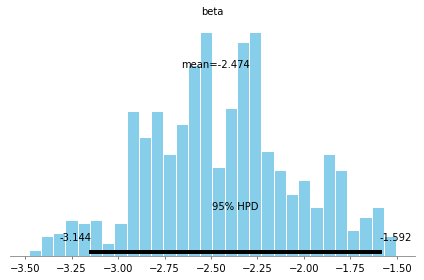

In [22]:
pm.plot_posterior(trace_, varnames=['beta'], color='#87ceeb')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12DC3E90>,
      dtype=object)

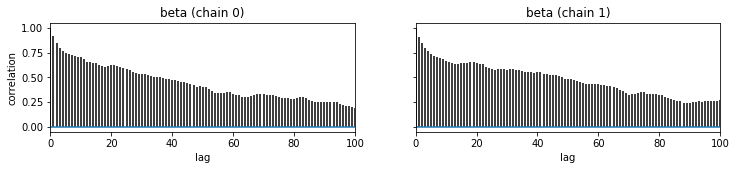

In [23]:
pm.autocorrplot(trace_, varnames=['beta'])

In [24]:
base_hazard = trace_['lambda0']
met_hazard = trace_['lambda0'] * np.exp(np.atleast_2d(trace_['beta']).T)

In [25]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [26]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label)


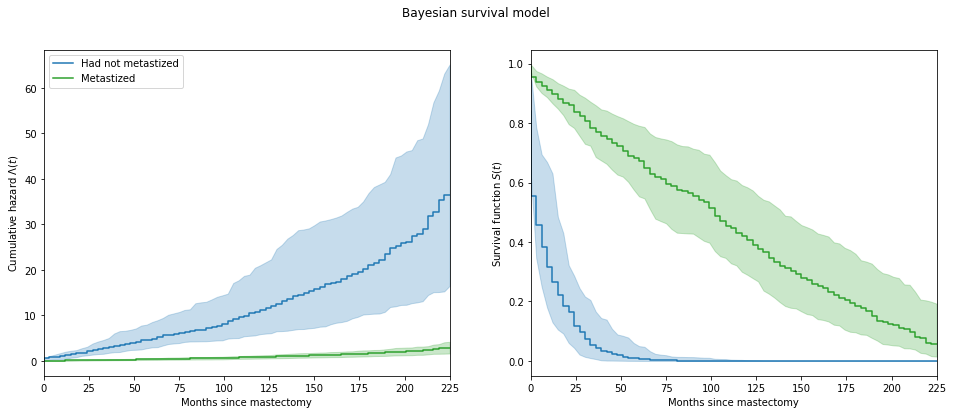

In [27]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
              hazard_ax, color=blue, label='Had not metastized')
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='Metastized')

hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel('Months since mastectomy')

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$')

hazard_ax.legend(loc=2)

plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel('Months since mastectomy')

surv_ax.set_ylabel('Survival function $S(t)$')

fig.suptitle('Bayesian survival model')